# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import sklearn
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer

# magic word for producing visualizations in notebook
%matplotlib inline

pd.options.display.max_rows = None
pd.options.display.max_columns = None

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [2]:
# Load in the general demographics data.
general_demo = pd.read_csv('Udacity_AZDIAS_Subset.csv', sep=';')

# Load in the feature summary file.
feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv', sep=';')

In [3]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).
print(general_demo.shape) 
general_demo.head()

(891221, 85)


,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,GEBURTSJAHR,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,LP_FAMILIE_FEIN,LP_FAMILIE_GROB,LP_STATUS_FEIN,LP_STATUS_GROB,NATIONALITAET_KZ,PRAEGENDE_JUGENDJAHRE,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SHOPPER_TYP,SOHO_KZ,TITEL_KZ,VERS_TYP,ZABEOTYP,ALTER_HH,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,KK_KUNDENTYP,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,GEBAEUDETYP,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ,WOHNLAGE,CAMEO_DEUG_2015,CAMEO_DEU_2015,CAMEO_INTL_2015,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_BAUMAX,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,4,0,10.0,0,-1,15.0,4.0,2.0,2.0,1.0,1.0,0,0,5.0,2,6,7,5,1,5,3,3,4,7,6,6,5,3,-1,NaN,NaN,-1,3,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5.0,1,5,2,5,4,5,1,1996,10.0,0,3,21.0,6.0,5.0,3.0,2.0,1.0,1,14,1.0,5,4,4,3,1,2,2,3,6,4,7,4,7,6,3,1.0,0.0,2,5,0.0,2.0,0.0,6.0,NaN,3.0,9.0,11.0,0.0,8.0,1.0,1992.0,W,4.0,8,8A,51,0.0,0.0,0.0,2.0,5.0,1.0,6.0,3.0,8.0,3.0,2.0,1.0,3.0,3.0,963.0,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,-1,3,2,3.0,1,4,1,2,3,5,1,1979,10.0,1,3,3.0,1.0,1.0,1.0,3.0,2.0,1,15,3.0,4,1,3,3,4,4,6,3,4,7,7,7,3,3,2,0.0,0.0,1,5,17.0,1.0,0.0,4.0,NaN,3.0,9.0,10.0,0.0,1.0,5.0,1992.0,W,2.0,4,4C,24,1.0,3.0,1.0,0.0,0.0,3.0,2.0,4.0,4.0,4.0,2.0,3.0,2.0,2.0,712.0,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2,4,2,2.0,4,2,5,2,1,2,6,1957,1.0,0,2,0.0,0.0,0.0,0.0,9.0,4.0,1,8,2.0,5,1,2,1,4,4,7,4,3,4,4,5,4,4,1,0.0,0.0,1,3,13.0,0.0,0.0,1.0,NaN,NaN,9.0,1.0,0.0,1.0,4.0,1997.0,W,7.0,2,2A,12,4.0,1.0,0.0,0.0,1.0,4.0,4.0,2.0,6.0,4.0,0.0,4.0,1.0,0.0,596.0,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,-1,3,1,5.0,4,3,4,1,3,2,5,1963,5.0,0,3,32.0,10.0,10.0,5.0,3.0,2.0,1,8,5.0,6,4,4,2,7,4,4,6,2,3,2,2,4,2,2,0.0,0.0,2,4,20.0,4.0,0.0,5.0,1.0,2.0,9.0,3.0,0.0,1.0,4.0,1992.0,W,3.0,6,6B,43,1.0,4.0,1.0,0.0,0.0,3.0,2.0,5.0,1.0,5.0,3.0,3.0,5.0,5.0,435.0,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


In [4]:
general_demo.describe()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,GEBURTSJAHR,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,LP_FAMILIE_FEIN,LP_FAMILIE_GROB,LP_STATUS_FEIN,LP_STATUS_GROB,NATIONALITAET_KZ,PRAEGENDE_JUGENDJAHRE,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SHOPPER_TYP,SOHO_KZ,TITEL_KZ,VERS_TYP,ZABEOTYP,ALTER_HH,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,KK_KUNDENTYP,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,GEBAEUDETYP,KONSUMNAEHE,MIN_GEBAEUDEJAHR,WOHNLAGE,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_BAUMAX,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
count,891221.000000,891221.000000,891221.000000,886367.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,886367.000000,891221.000000,891221.000000,886367.000000,886367.000000,886367.000000,886367.000000,886367.000000,886367.000000,891221.000000,891221.000000,886367.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,817722.000000,817722.000000,891221.000000,891221.000000,817722.000000,817722.000000,817722.000000,872873.000000,306609.000000,783619.000000,817722.000000,798073.000000,794213.000000,798073.000000,817252.000000,798073.000000,798073.000000,757897.000000,757897.000000,757897.000000,757897.000000,757897.000000,757897.000000,797481.000000,797481.000000,797481.000000,798066.000000,770025.000000,757897.000000,886367.000000,770025.000000,785421.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,794005.000000,794005.000000,794005.00000
mean,-0.358435,2.777398,1.522098,3.632838,3.074528,2.821039,3.401106,3.033328,2.874167,3.075121,3.790586,1101.178533,7.350304,0.196612,1.792102,14.622637,4.453621,3.599574,2.185966,4.791151,2.432575,1.026827,8.154346,3.419630,3.945860,4.272729,4.240609,4.001597,4.023709,4.359086,4.481405,4.025014,3.910139,4.763223,4.667550,4.445007,4.256076,3.661784,1.266967,0.008423,0.003483,1.197852,3.362438,10.864126,1.727637,0.004162,4.207243,3.410640,3.933406,7.908791,8.287263,0.040647,2.798641,3.018452,1993.277011,4.052836,1.494277,1.265584,0.624525,0.305927,1.389552,3.158580,4.153043,3.939172,4.549491,3.738306,2.592991,2.963540,2.698691,4.257967,619.701439,2.253330,2.801858,1.595426,0.699166,1.943913,3.612821,3.381087,3.167854,5.293002,3.07222
std,1.198724,1.068775,0.499512,1.595021,1.321055,1.464749,1.322134,1.529603,1.486731,1.353248,1.987876,976.583551,3.525723,0.397437,1.269062,12.616883,3.855639,3.926486,1.756537,3.425305,1.474315,0.586634,4.844532,1.417741,1.946564,1.915885,2.007373,1.857540,2.077746,2.022829,1.807552,1.903816,1.580306,1.830789,1.795712,1.852412,1.770137,1.707637,1.287435,0.091392,0.084957,0.952532,1.352704,7.639683,1.155849,0.068855,1.624057,1.628844,1.964701,1.923137,15.628087,0.324028,2.656713,1.550312,3.332739,1.949539,1.403961,1.245178,1.013443,0.638725,1.779483,1.329537,2.183710,1.718996,2.028919,0.923193,1.119052,1.428882,1.521524,2.030385,340.034318,0.972008,0.920309,0.986736,0.727137,1.459654,0.973967,1.111598,1.002376,2.303739,1.36298
min,-1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000

In [5]:
print(feat_info.shape) 
feat_info.head()

(85, 4)


,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]


In [6]:
feat_info.describe()

,attribute,information_level,type,missing_or_unknown
count,85,85,85,85
unique,85,9,5,9
top,AGER_TYP,person,ordinal,[-1]
freq,1,43,49,26


> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`. 

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [7]:
#count number of nans before changing missing/unknown values to nans
before_clean_nan = general_demo.isna().sum().sum()
print(before_clean_nan)

4896838


Investigate the missing / unknown values and create a function to change these from a list of strings to list of lists

In [8]:
#identify values for missing/unknowns
miss_uknwns_values = pd.unique(feat_info["missing_or_unknown"])
miss_uknwns_values

array(['[-1,0]', '[-1,0,9]', '[0]', '[-1]', '[]', '[-1,9]', '[-1,X]',
       '[XX]', '[-1,XX]'], dtype=object)

In [9]:
# miss_uknwns_values are all strings so parse the string representations into lists
def convert_list_string(list_string):
    # Remove the square brackets
    list_string = list_string.strip('[]')
    # Handle empty list
    if list_string == '':
        return []
    # Split the string by commas and process each element
    elements = list_string.split(',')
    parsed_elements = []
    for elem in elements:
        # Check if the element can be converted to an integer
        try:
            parsed_elements.append(int(elem))
        except ValueError:
            parsed_elements.append(elem)
    return parsed_elements

parsed_values = [convert_list_string(value) for value in miss_uknwns_values]
print(parsed_values)

[[-1, 0], [-1, 0, 9], [0], [-1], [], [-1, 9], [-1, 'X'], ['XX'], [-1, 'XX']]


In [10]:
#create list of missing value lists:
missing_list = [convert_list_string(value) for value in feat_info['missing_or_unknown']] 
print(len(missing_list), missing_list)

85 [[-1, 0], [-1, 0, 9], [-1, 0], [0], [-1], [-1], [-1], [-1], [-1], [-1], [-1], [0], [], [], [-1, 0], [0], [0], [0], [0], [0], [0], [-1, 0], [-1, 0], [0], [-1, 9], [-1, 9], [-1, 9], [-1, 9], [-1, 9], [-1, 9], [-1, 9], [-1, 9], [-1, 9], [-1, 9], [-1, 9], [-1, 9], [-1, 9], [-1, 9], [-1], [-1], [-1, 0], [-1], [-1, 9], [0], [], [], [-1, 0], [-1], [-1, 0], [-1, 0], [0], [], [-1, 0], [], [0], [-1], [-1], [-1, 'X'], ['XX'], [-1, 'XX'], [-1], [-1], [-1], [-1], [-1, 0], [-1, 0], [-1], [-1], [-1], [], [-1, 0], [], [], [-1, 0], [], [-1], [-1], [-1], [-1], [-1, 0], [-1], [-1], [-1, 9], [-1, 0], [-1, 9]]


In [11]:
#create dictionary of attributes and their respective missing/unknown values:
miss_dict = dict(zip(feat_info['attribute'], missing_list))
print(len(miss_dict), miss_dict)

85 {'AGER_TYP': [-1, 0], 'ALTERSKATEGORIE_GROB': [-1, 0, 9], 'ANREDE_KZ': [-1, 0], 'CJT_GESAMTTYP': [0], 'FINANZ_MINIMALIST': [-1], 'FINANZ_SPARER': [-1], 'FINANZ_VORSORGER': [-1], 'FINANZ_ANLEGER': [-1], 'FINANZ_UNAUFFAELLIGER': [-1], 'FINANZ_HAUSBAUER': [-1], 'FINANZTYP': [-1], 'GEBURTSJAHR': [0], 'GFK_URLAUBERTYP': [], 'GREEN_AVANTGARDE': [], 'HEALTH_TYP': [-1, 0], 'LP_LEBENSPHASE_FEIN': [0], 'LP_LEBENSPHASE_GROB': [0], 'LP_FAMILIE_FEIN': [0], 'LP_FAMILIE_GROB': [0], 'LP_STATUS_FEIN': [0], 'LP_STATUS_GROB': [0], 'NATIONALITAET_KZ': [-1, 0], 'PRAEGENDE_JUGENDJAHRE': [-1, 0], 'RETOURTYP_BK_S': [0], 'SEMIO_SOZ': [-1, 9], 'SEMIO_FAM': [-1, 9], 'SEMIO_REL': [-1, 9], 'SEMIO_MAT': [-1, 9], 'SEMIO_VERT': [-1, 9], 'SEMIO_LUST': [-1, 9], 'SEMIO_ERL': [-1, 9], 'SEMIO_KULT': [-1, 9], 'SEMIO_RAT': [-1, 9], 'SEMIO_KRIT': [-1, 9], 'SEMIO_DOM': [-1, 9], 'SEMIO_KAEM': [-1, 9], 'SEMIO_PFLICHT': [-1, 9], 'SEMIO_TRADV': [-1, 9], 'SHOPPER_TYP': [-1], 'SOHO_KZ': [-1], 'TITEL_KZ': [-1, 0], 'VERS_TYP': [-1

In [12]:
#go through each column in demographic file, count missing / unknown values
def count_missing():
    miss_counts = {}
    for attribute, missing_values in miss_dict.items(): 
        miss_counts[attribute] = 0
        for value in missing_values:
            miss_counts[attribute] += (general_demo[attribute] == value).sum()
    return miss_counts

missing_before = count_missing()
print(sum(missing_before.values()))

3477091


In [13]:
missing_before

{'AGER_TYP': 685843,
 'ALTERSKATEGORIE_GROB': 2881,
 'ANREDE_KZ': 0,
 'CJT_GESAMTTYP': 0,
 'FINANZ_MINIMALIST': 0,
 'FINANZ_SPARER': 0,
 'FINANZ_VORSORGER': 0,
 'FINANZ_ANLEGER': 0,
 'FINANZ_UNAUFFAELLIGER': 0,
 'FINANZ_HAUSBAUER': 0,
 'FINANZTYP': 0,
 'GEBURTSJAHR': 392318,
 'GFK_URLAUBERTYP': 0,
 'GREEN_AVANTGARDE': 0,
 'HEALTH_TYP': 111196,
 'LP_LEBENSPHASE_FEIN': 92778,
 'LP_LEBENSPHASE_GROB': 89718,
 'LP_FAMILIE_FEIN': 72938,
 'LP_FAMILIE_GROB': 72938,
 'LP_STATUS_FEIN': 0,
 'LP_STATUS_GROB': 0,
 'NATIONALITAET_KZ': 108315,
 'PRAEGENDE_JUGENDJAHRE': 108164,
 'RETOURTYP_BK_S': 0,
 'SEMIO_SOZ': 0,
 'SEMIO_FAM': 0,
 'SEMIO_REL': 0,
 'SEMIO_MAT': 0,
 'SEMIO_VERT': 0,
 'SEMIO_LUST': 0,
 'SEMIO_ERL': 0,
 'SEMIO_KULT': 0,
 'SEMIO_RAT': 0,
 'SEMIO_KRIT': 0,
 'SEMIO_DOM': 0,
 'SEMIO_KAEM': 0,
 'SEMIO_PFLICHT': 0,
 'SEMIO_TRADV': 0,
 'SHOPPER_TYP': 111196,
 'SOHO_KZ': 0,
 'TITEL_KZ': 815562,
 'VERS_TYP': 111196,
 'ZABEOTYP': 0,
 'ALTER_HH': 236768,
 'ANZ_PERSONEN': 0,
 'ANZ_TITEL': 0,
 'HH_

In [14]:
#convert missing values to nan 
for attribute, missing_values in miss_dict.items():
    for value in missing_values:
        general_demo[attribute] = general_demo[attribute].replace(value, np.nan)

missing_after = count_missing()
print(sum(missing_after.values()))

0


In [15]:
missing_after

{'AGER_TYP': 0,
 'ALTERSKATEGORIE_GROB': 0,
 'ANREDE_KZ': 0,
 'CJT_GESAMTTYP': 0,
 'FINANZ_MINIMALIST': 0,
 'FINANZ_SPARER': 0,
 'FINANZ_VORSORGER': 0,
 'FINANZ_ANLEGER': 0,
 'FINANZ_UNAUFFAELLIGER': 0,
 'FINANZ_HAUSBAUER': 0,
 'FINANZTYP': 0,
 'GEBURTSJAHR': 0,
 'GFK_URLAUBERTYP': 0,
 'GREEN_AVANTGARDE': 0,
 'HEALTH_TYP': 0,
 'LP_LEBENSPHASE_FEIN': 0,
 'LP_LEBENSPHASE_GROB': 0,
 'LP_FAMILIE_FEIN': 0,
 'LP_FAMILIE_GROB': 0,
 'LP_STATUS_FEIN': 0,
 'LP_STATUS_GROB': 0,
 'NATIONALITAET_KZ': 0,
 'PRAEGENDE_JUGENDJAHRE': 0,
 'RETOURTYP_BK_S': 0,
 'SEMIO_SOZ': 0,
 'SEMIO_FAM': 0,
 'SEMIO_REL': 0,
 'SEMIO_MAT': 0,
 'SEMIO_VERT': 0,
 'SEMIO_LUST': 0,
 'SEMIO_ERL': 0,
 'SEMIO_KULT': 0,
 'SEMIO_RAT': 0,
 'SEMIO_KRIT': 0,
 'SEMIO_DOM': 0,
 'SEMIO_KAEM': 0,
 'SEMIO_PFLICHT': 0,
 'SEMIO_TRADV': 0,
 'SHOPPER_TYP': 0,
 'SOHO_KZ': 0,
 'TITEL_KZ': 0,
 'VERS_TYP': 0,
 'ZABEOTYP': 0,
 'ALTER_HH': 0,
 'ANZ_PERSONEN': 0,
 'ANZ_TITEL': 0,
 'HH_EINKOMMEN_SCORE': 0,
 'KK_KUNDENTYP': 0,
 'W_KEIT_KIND_HH': 0,
 

In [16]:
#check that the correct terms have been updated
# sum of missing values should equal the number of new nans created:

#missing values detected before update
print(sum(missing_before.values()))

3477091


In [17]:
#number new nans created
after_clean_nan = general_demo.isna().sum().sum()
after_clean_nan - before_clean_nan

3477091

#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

In [18]:
# Perform an assessment of how much missing data there is in each column of the
# dataset.

#create series with counts of missing values:
nan_props = general_demo.isna().sum()/len(general_demo) *100
nan_props.sort_values(ascending=True,inplace=True)
nan_props

ZABEOTYP                  0.000000
SEMIO_TRADV               0.000000
SEMIO_PFLICHT             0.000000
SEMIO_KAEM                0.000000
SEMIO_DOM                 0.000000
SEMIO_KRIT                0.000000
SEMIO_RAT                 0.000000
SEMIO_KULT                0.000000
SEMIO_ERL                 0.000000
SEMIO_LUST                0.000000
SEMIO_VERT                0.000000
SEMIO_MAT                 0.000000
SEMIO_REL                 0.000000
SEMIO_SOZ                 0.000000
SEMIO_FAM                 0.000000
FINANZ_VORSORGER          0.000000
ANREDE_KZ                 0.000000
FINANZ_MINIMALIST         0.000000
FINANZ_SPARER             0.000000
FINANZ_ANLEGER            0.000000
FINANZ_UNAUFFAELLIGER     0.000000
FINANZ_HAUSBAUER          0.000000
GREEN_AVANTGARDE          0.000000
FINANZTYP                 0.000000
ALTERSKATEGORIE_GROB      0.323264
GFK_URLAUBERTYP           0.544646
LP_STATUS_GROB            0.544646
LP_STATUS_FEIN            0.544646
ONLINE_AFFINITAET   

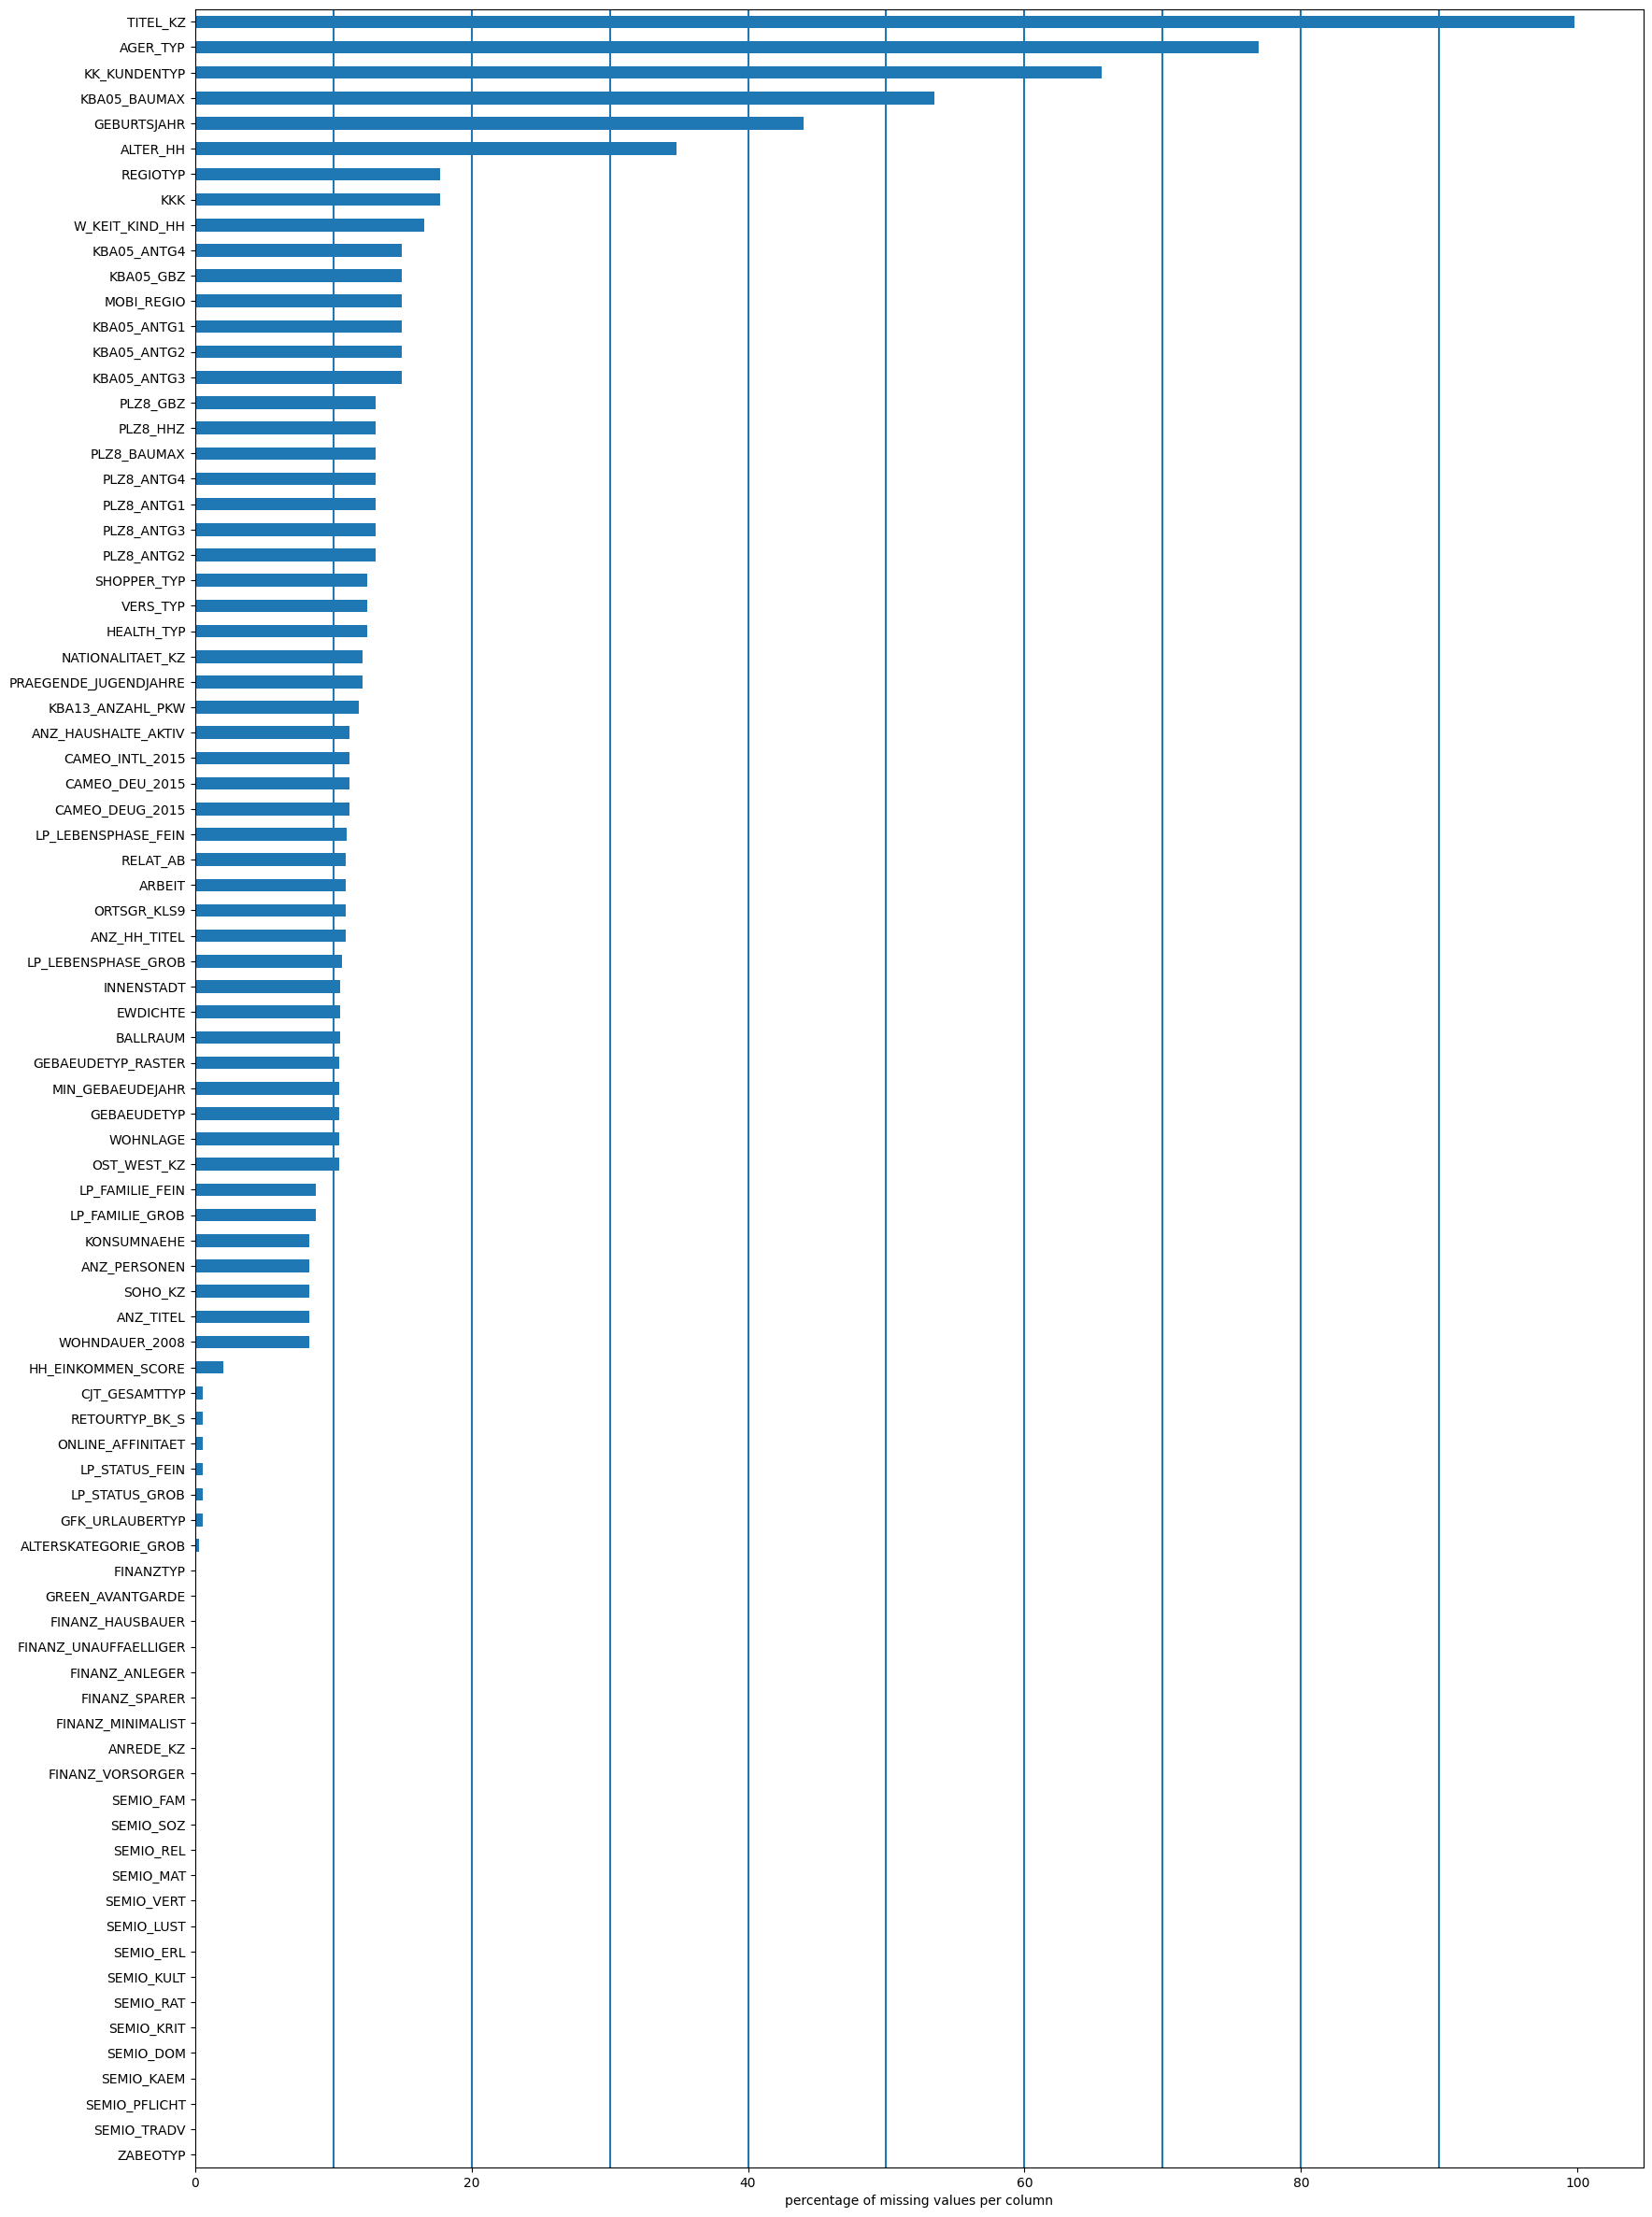

In [19]:
nan_props.plot.barh(figsize=(20,30))
plt.xlabel('percentage of missing values per column')
xcoords = range(10,100,10)
for xc in xcoords:
    plt.axvline(x=xc)
plt.show()

From the above graph we can see that there are six columns with far more missing values than other columns. So we will create a filtered dictionary to capture the six outliers: 

In [20]:
high_nans = {k:v  for (k,v) in nan_props.items() if v > 18}
high_nans

{'ALTER_HH': 34.81369940789097,
 'GEBURTSJAHR': 44.02028228688507,
 'KBA05_BAUMAX': 53.468668265222654,
 'KK_KUNDENTYP': 65.59674873011295,
 'AGER_TYP': 76.95543529607134,
 'TITEL_KZ': 99.75763587258379}

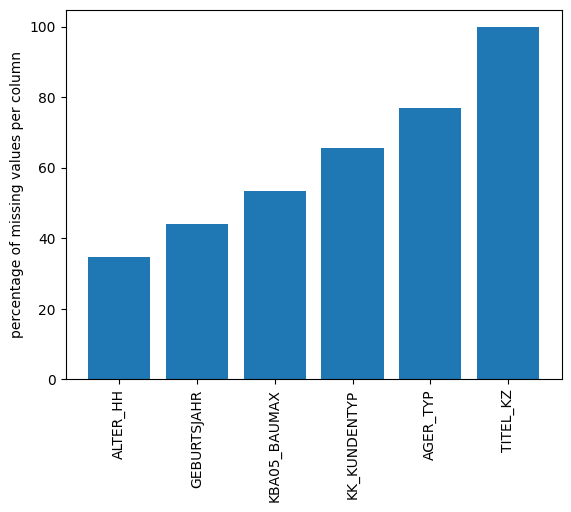

In [21]:
plt.bar(high_nans.keys(),high_nans.values())
plt.xticks(rotation=90)
plt.ylabel('percentage of missing values per column')
plt.show;

In [22]:
# Remove the outlier columns from the dataset. (You'll perform other data
# engineering tasks such as re-encoding and imputation later.)
general_demo.drop(columns=high_nans.keys(),axis="columns",inplace=True)
general_demo.shape

(891221, 79)

In [23]:
general_demo.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,LP_FAMILIE_FEIN,LP_FAMILIE_GROB,LP_STATUS_FEIN,LP_STATUS_GROB,NATIONALITAET_KZ,PRAEGENDE_JUGENDJAHRE,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SHOPPER_TYP,SOHO_KZ,VERS_TYP,ZABEOTYP,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,GEBAEUDETYP,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ,WOHNLAGE,CAMEO_DEUG_2015,CAMEO_DEU_2015,CAMEO_INTL_2015,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,2.0,1,2.0,3,4,3,5,5,3,4,10.0,0,NaN,15.0,4.0,2.0,2.0,1.0,1.0,NaN,NaN,5.0,2,6,7,5,1,5,3,3,4,7,6,6,5,3,NaN,NaN,NaN,3,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1.0,2,5.0,1,5,2,5,4,5,1,10.0,0,3.0,21.0,6.0,5.0,3.0,2.0,1.0,1.0,14.0,1.0,5,4,4,3,1,2,2,3,6,4,7,4,7,6,3.0,1.0,2.0,5,2.0,0.0,6.0,3.0,9.0,11.0,0.0,8.0,1.0,1992.0,W,4.0,8,8A,51,0.0,0.0,0.0,2.0,1.0,6.0,3.0,8.0,3.0,2.0,1.0,3.0,3.0,963.0,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,3.0,2,3.0,1,4,1,2,3,5,1,10.0,1,3.0,3.0,1.0,1.0,1.0,3.0,2.0,1.0,15.0,3.0,4,1,3,3,4,4,6,3,4,7,7,7,3,3,2.0,0.0,1.0,5,1.0,0.0,4.0,3.0,9.0,10.0,0.0,1.0,5.0,1992.0,W,2.0,4,4C,24,1.0,3.0,1.0,0.0,3.0,2.0,4.0,4.0,4.0,2.0,3.0,2.0,2.0,712.0,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,4.0,2,2.0,4,2,5,2,1,2,6,1.0,0,2.0,NaN,NaN,NaN,NaN,9.0,4.0,1.0,8.0,2.0,5,1,2,1,4,4,7,4,3,4,4,5,4,4,1.0,0.0,1.0,3,0.0,0.0,1.0,NaN,9.0,1.0,0.0,1.0,4.0,1997.0,W,7.0,2,2A,12,4.0,1.0,0.0,0.0,4.0,4.0,2.0,6.0,4.0,NaN,4.0,1.0,NaN,596.0,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,3.0,1,5.0,4,3,4,1,3,2,5,5.0,0,3.0,32.0,10.0,10.0,5.0,3.0,2.0,1.0,8.0,5.0,6,4,4,2,7,4,4,6,2,3,2,2,4,2,2.0,0.0,2.0,4,4.0,0.0,5.0,2.0,9.0,3.0,0.0,1.0,4.0,1992.0,W,3.0,6,6B,43,1.0,4.0,1.0,0.0,3.0,2.0,5.0,1.0,5.0,3.0,3.0,5.0,5.0,435.0,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


#### Discussion 1.1.2: Assess Missing Data in Each Column

Of the 85 original columns 6 had an exceptionally high proportion of missing values (over 34%). These were removed. 

The remaining 79 columns have the following missing value proportions:
- 3 columns have missing values for between 16.6% and 18% of all their rows 
- 37 columns have between 10% and 15%
- 7 columns have just over 8%
- 1 column have just over 2%
- 31 columns have no missing values

#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

In [24]:
# How much data is missing in each row of the dataset?
row_nan_counts = general_demo.isna().sum(axis=1)
row_nan_counts.describe() 

count    891221.000000
mean          5.649894
std          13.234687
min           0.000000
25%           0.000000
50%           0.000000
75%           3.000000
max          49.000000
dtype: float64

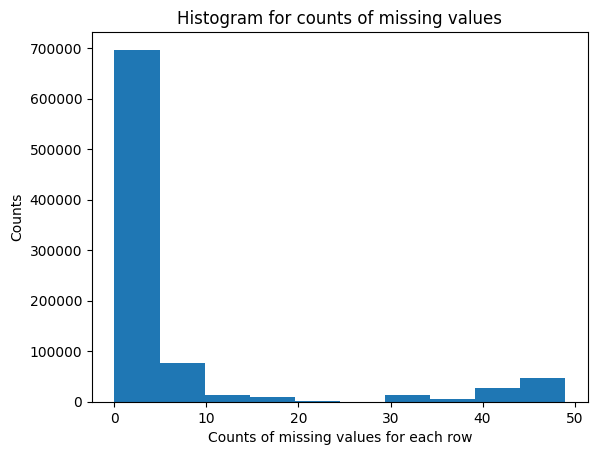

In [25]:
plt.hist(row_nan_counts)
plt.xlabel('Counts of missing values for each row')
plt.ylabel('Counts')
plt.title('Histogram for counts of missing values')
plt.show()

As we can see in the above histogram there is a visual difference between those rows that have nans for less than 28 of their columns vs rows that have nans for more than 28 columns

In [26]:
high_nan_rows = {k:v  for (k,v) in row_nan_counts.items() if v > 28}
len(high_nan_rows)

93172

In [27]:
# Write code to divide the data into two subsets based on the number of missing
# values in each row.
missing_less_28 = general_demo[row_nan_counts<28]
missing_more_28 = general_demo[row_nan_counts>=28]

In [28]:
missing_less_28.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,LP_FAMILIE_FEIN,LP_FAMILIE_GROB,LP_STATUS_FEIN,LP_STATUS_GROB,NATIONALITAET_KZ,PRAEGENDE_JUGENDJAHRE,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SHOPPER_TYP,SOHO_KZ,VERS_TYP,ZABEOTYP,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,GEBAEUDETYP,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ,WOHNLAGE,CAMEO_DEUG_2015,CAMEO_DEU_2015,CAMEO_INTL_2015,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
1,1.0,2,5.0,1,5,2,5,4,5,1,10.0,0,3.0,21.0,6.0,5.0,3.0,2.0,1.0,1.0,14.0,1.0,5,4,4,3,1,2,2,3,6,4,7,4,7,6,3.0,1.0,2.0,5,2.0,0.0,6.0,3.0,9.0,11.0,0.0,8.0,1.0,1992.0,W,4.0,8,8A,51,0.0,0.0,0.0,2.0,1.0,6.0,3.0,8.0,3.0,2.0,1.0,3.0,3.0,963.0,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,3.0,2,3.0,1,4,1,2,3,5,1,10.0,1,3.0,3.0,1.0,1.0,1.0,3.0,2.0,1.0,15.0,3.0,4,1,3,3,4,4,6,3,4,7,7,7,3,3,2.0,0.0,1.0,5,1.0,0.0,4.0,3.0,9.0,10.0,0.0,1.0,5.0,1992.0,W,2.0,4,4C,24,1.0,3.0,1.0,0.0,3.0,2.0,4.0,4.0,4.0,2.0,3.0,2.0,2.0,712.0,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,4.0,2,2.0,4,2,5,2,1,2,6,1.0,0,2.0,NaN,NaN,NaN,NaN,9.0,4.0,1.0,8.0,2.0,5,1,2,1,4,4,7,4,3,4,4,5,4,4,1.0,0.0,1.0,3,0.0,0.0,1.0,NaN,9.0,1.0,0.0,1.0,4.0,1997.0,W,7.0,2,2A,12,4.0,1.0,0.0,0.0,4.0,4.0,2.0,6.0,4.0,NaN,4.0,1.0,NaN,596.0,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,3.0,1,5.0,4,3,4,1,3,2,5,5.0,0,3.0,32.0,10.0,10.0,5.0,3.0,2.0,1.0,8.0,5.0,6,4,4,2,7,4,4,6,2,3,2,2,4,2,2.0,0.0,2.0,4,4.0,0.0,5.0,2.0,9.0,3.0,0.0,1.0,4.0,1992.0,W,3.0,6,6B,43,1.0,4.0,1.0,0.0,3.0,2.0,5.0,1.0,5.0,3.0,3.0,5.0,5.0,435.0,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0
5,1.0,2,2.0,3,1,5,2,2,5,2,1.0,0,3.0,8.0,2.0,1.0,1.0,4.0,2.0,1.0,3.0,3.0,2,4,7,4,2,2,2,5,7,4,4,4,7,6,0.0,0.0,2.0,4,1.0,0.0,5.0,6.0,9.0,5.0,0.0,1.0,5.0,1992.0,W,7.0,8,8C,54,2.0,2.0,0.0,0.0,4.0,6.0,2.0,7.0,4.0,4.0,4.0,1.0,5.0,1300.0,2.0,3.0,1.0,1.0,1.0,5.0,5.0,2.0,3.0,3.0


In [29]:
missing_less_28.shape

(798044, 79)

In [30]:
missing_more_28.shape

(93177, 79)

In [31]:
#columns=null_values[null_values<18].index
low_missing_columns = list(nan_props[nan_props<30].index[:5])
low_missing_columns

['ZABEOTYP', 'SEMIO_TRADV', 'SEMIO_PFLICHT', 'SEMIO_KAEM', 'SEMIO_DOM']

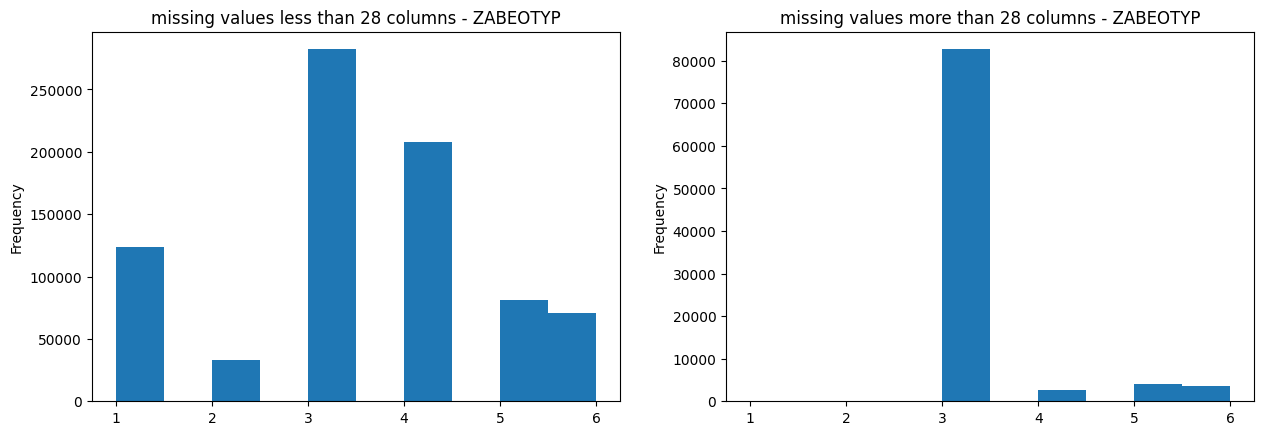

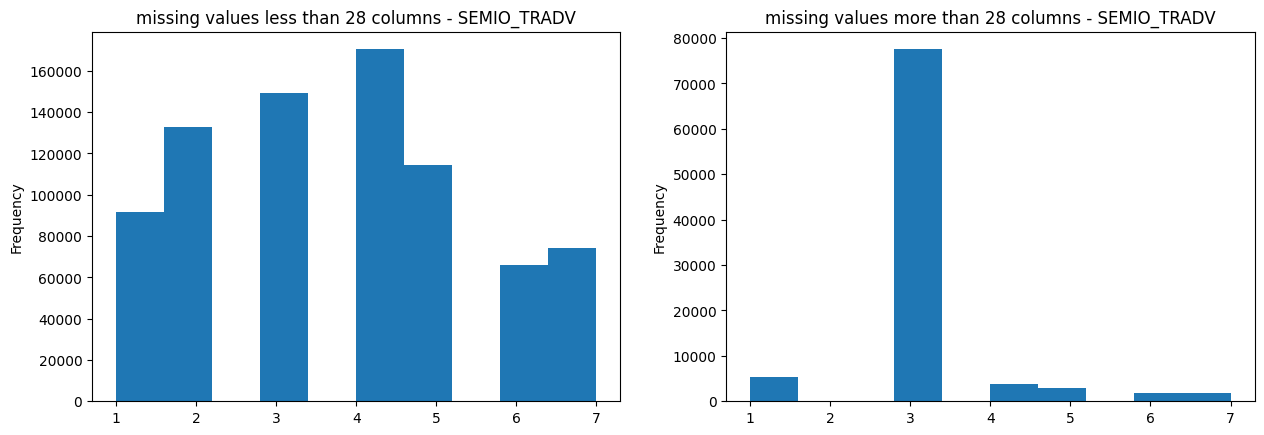

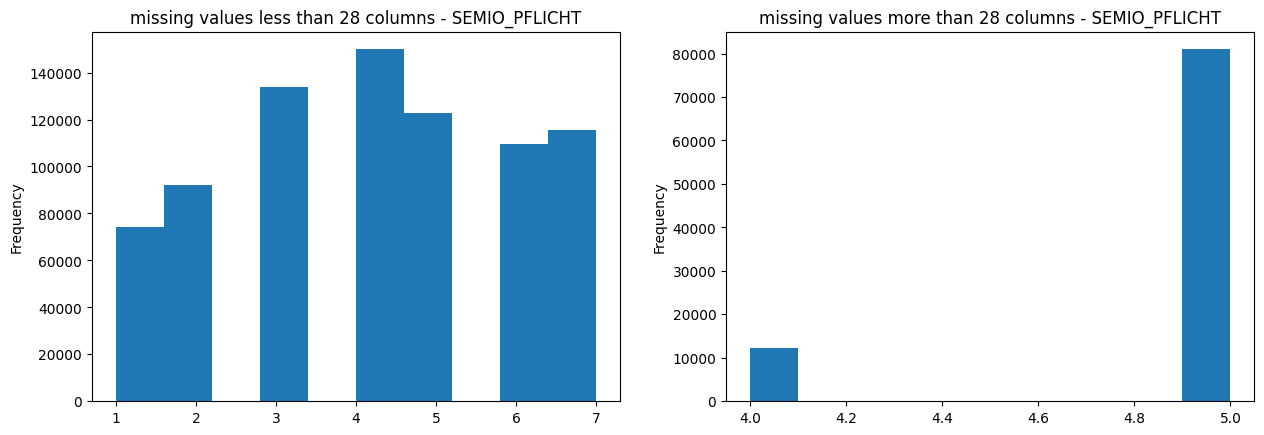

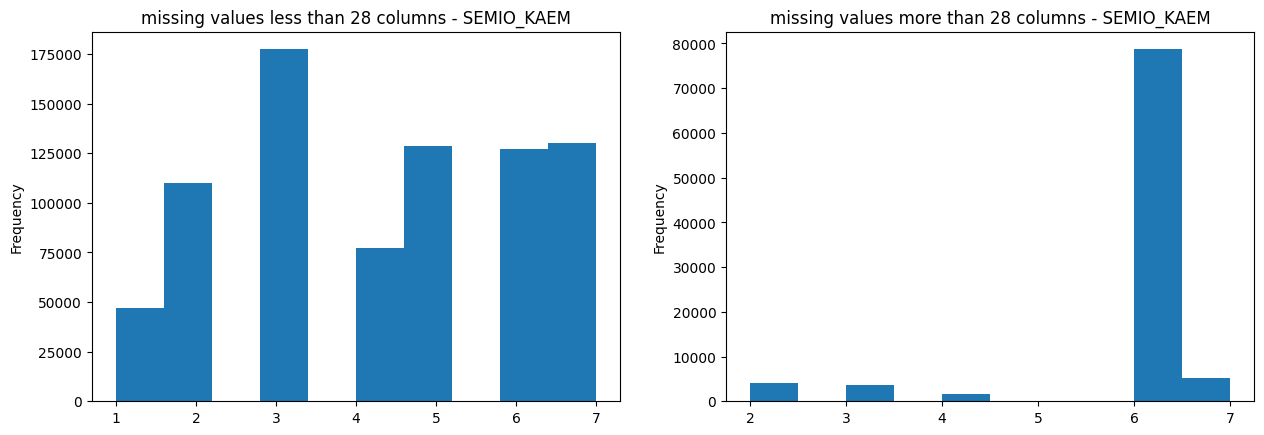

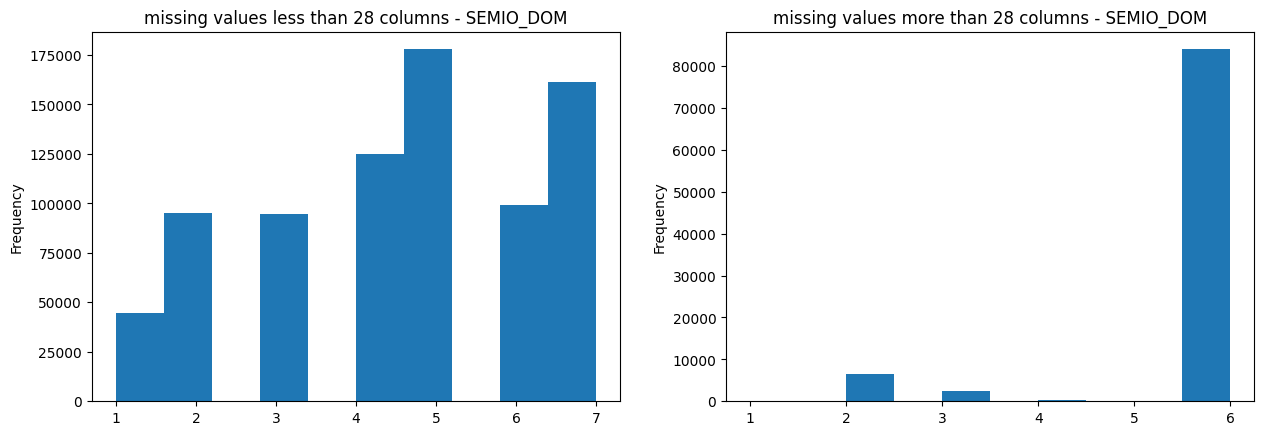

In [32]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.   
for column in low_missing_columns:
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_figwidth(15)
    ax1.set_title(f'missing values less than 28 columns - {column}')
    missing_less_28.loc[:,column].plot.hist(ax=ax1) 

    ax2.set_title(f'missing values more than 28 columns - {column}')
    missing_more_28.loc[:,column].plot.hist(ax=ax2)
    
    plt.show()

#### Discussion 1.1.3: Assess Missing Data in Each Row

As can be seen in the above comparison plots, the data with lots of missing values is qualitatively different from data with few or no missing values. As a result, further analysis would normally be required before dropping these rows. However, the guideline given by Udacity is to "...continue analysis for now using just the subset of the data with few or no missing values." Therefore from now on we will use only the subest of the general demographic data that is in the missing_less_28 dataframe.

### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [33]:
# How many features are there of each data type?
feat_info["type"].value_counts()

type
ordinal        49
categorical    21
numeric         7
mixed           7
interval        1
Name: count, dtype: int64

#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [34]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?
categorical_columns = list(feat_info[feat_info['type'].isin(['categorical'])]['attribute'])
categorical_columns

['AGER_TYP',
 'ANREDE_KZ',
 'CJT_GESAMTTYP',
 'FINANZTYP',
 'GFK_URLAUBERTYP',
 'GREEN_AVANTGARDE',
 'LP_FAMILIE_FEIN',
 'LP_FAMILIE_GROB',
 'LP_STATUS_FEIN',
 'LP_STATUS_GROB',
 'NATIONALITAET_KZ',
 'SHOPPER_TYP',
 'SOHO_KZ',
 'TITEL_KZ',
 'VERS_TYP',
 'ZABEOTYP',
 'KK_KUNDENTYP',
 'GEBAEUDETYP',
 'OST_WEST_KZ',
 'CAMEO_DEUG_2015',
 'CAMEO_DEU_2015']

In [35]:
binary_nonnumeric_dict = {}
multi_categorical_dict = {}
checksum = 0
for column in categorical_columns:
    if column in list(missing_less_28):
        if len(missing_less_28[column].unique()) == 2:
            if missing_less_28[column].unique().dtype == 'object':
                binary_nonnumeric_dict[column] = missing_less_28[column].unique()
            else:
                print(f"{column} has numeric values - no action required")  
                checksum += 1
        else:
            multi_categorical_dict[column] = missing_less_28[column].unique()
    else:
        print(f"{column} is not in dataframe")
        checksum += 1
      
checksum += len(binary_nonnumeric_dict) +len(multi_categorical_dict)
print(f"checksum = {checksum}, len(categorical_columns) = {len(categorical_columns)}")

AGER_TYP is not in dataframe
ANREDE_KZ has numeric values - no action required
GREEN_AVANTGARDE has numeric values - no action required
SOHO_KZ has numeric values - no action required
TITEL_KZ is not in dataframe
KK_KUNDENTYP is not in dataframe
checksum = 21, len(categorical_columns) = 21


In [36]:
#View binary, non-numeric categories
binary_nonnumeric_dict

{'OST_WEST_KZ': array(['W', 'O'], dtype=object)}

In [37]:
missing_less_28["OST_WEST_KZ"].value_counts()

OST_WEST_KZ
W    629504
O    168540
Name: count, dtype: int64

In [38]:
#re-encode binary, non-numeric category
missing_less_28["OST_WEST_KZ"].replace({'W':0,'O':1},inplace=True)

missing_less_28["OST_WEST_KZ"].value_counts()

/tmp/ipykernel_99/970878691.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  missing_less_28["OST_WEST_KZ"].replace({'W':0,'O':1},inplace=True)


OST_WEST_KZ
0    629504
1    168540
Name: count, dtype: int64

In [39]:
#view other categorical fields
multi_categorical_dict

{'CJT_GESAMTTYP': array([ 5.,  3.,  2.,  4.,  1.,  6., nan]),
 'FINANZTYP': array([1, 6, 5, 2, 4, 3]),
 'GFK_URLAUBERTYP': array([10.,  1.,  5., 12.,  9.,  3.,  8., 11.,  4.,  2.,  7.,  6., nan]),
 'LP_FAMILIE_FEIN': array([ 5.,  1., nan, 10.,  2.,  7., 11.,  8.,  4.,  6.,  9.,  3.]),
 'LP_FAMILIE_GROB': array([ 3.,  1., nan,  5.,  2.,  4.]),
 'LP_STATUS_FEIN': array([ 2.,  3.,  9.,  4.,  1., 10.,  5.,  8.,  6.,  7., nan]),
 'LP_STATUS_GROB': array([ 1.,  2.,  4.,  5.,  3., nan]),
 'NATIONALITAET_KZ': array([ 1.,  3.,  2., nan]),
 'SHOPPER_TYP': array([ 3.,  2.,  1.,  0., nan]),
 'VERS_TYP': array([ 2.,  1., nan]),
 'ZABEOTYP': array([5, 3, 4, 1, 6, 2]),
 'GEBAEUDETYP': array([8., 1., 3., 2., 6., 4., 5.]),
 'CAMEO_DEUG_2015': array(['8', '4', '2', '6', '1', '9', '5', '7', nan, '3'], dtype=object),
 'CAMEO_DEU_2015': array(['8A', '4C', '2A', '6B', '8C', '4A', '2D', '1A', '1E', '9D', '5C',
        '8B', '7A', '5D', '9E', nan, '9B', '1B', '3D', '4E', '4B', '3C',
        '5A', '7B', '9A', 

In [40]:
#investigate the field that contains a lot of values
missing_less_28["CAMEO_DEU_2015"].nunique()

44

In [41]:
missing_less_28["CJT_GESAMTTYP"].unique()

array([ 5.,  3.,  2.,  4.,  1.,  6., nan])

In [42]:
#drop CAMEO_DEU_2015 as it contains 44 values 
# if this is left in it will extend processing time and my not help with clustering
#it can be addd back in at a later date if necessary
missing_less_28 = missing_less_28.drop("CAMEO_DEU_2015", axis=1)

In [43]:
list(missing_less_28)

['ALTERSKATEGORIE_GROB',
 'ANREDE_KZ',
 'CJT_GESAMTTYP',
 'FINANZ_MINIMALIST',
 'FINANZ_SPARER',
 'FINANZ_VORSORGER',
 'FINANZ_ANLEGER',
 'FINANZ_UNAUFFAELLIGER',
 'FINANZ_HAUSBAUER',
 'FINANZTYP',
 'GFK_URLAUBERTYP',
 'GREEN_AVANTGARDE',
 'HEALTH_TYP',
 'LP_LEBENSPHASE_FEIN',
 'LP_LEBENSPHASE_GROB',
 'LP_FAMILIE_FEIN',
 'LP_FAMILIE_GROB',
 'LP_STATUS_FEIN',
 'LP_STATUS_GROB',
 'NATIONALITAET_KZ',
 'PRAEGENDE_JUGENDJAHRE',
 'RETOURTYP_BK_S',
 'SEMIO_SOZ',
 'SEMIO_FAM',
 'SEMIO_REL',
 'SEMIO_MAT',
 'SEMIO_VERT',
 'SEMIO_LUST',
 'SEMIO_ERL',
 'SEMIO_KULT',
 'SEMIO_RAT',
 'SEMIO_KRIT',
 'SEMIO_DOM',
 'SEMIO_KAEM',
 'SEMIO_PFLICHT',
 'SEMIO_TRADV',
 'SHOPPER_TYP',
 'SOHO_KZ',
 'VERS_TYP',
 'ZABEOTYP',
 'ANZ_PERSONEN',
 'ANZ_TITEL',
 'HH_EINKOMMEN_SCORE',
 'W_KEIT_KIND_HH',
 'WOHNDAUER_2008',
 'ANZ_HAUSHALTE_AKTIV',
 'ANZ_HH_TITEL',
 'GEBAEUDETYP',
 'KONSUMNAEHE',
 'MIN_GEBAEUDEJAHR',
 'OST_WEST_KZ',
 'WOHNLAGE',
 'CAMEO_DEUG_2015',
 'CAMEO_INTL_2015',
 'KBA05_ANTG1',
 'KBA05_ANTG2',
 'KBA0

In [44]:
#remove form dictionary
del multi_categorical_dict["CAMEO_DEU_2015"]

In [45]:
multi_categorical_dict

{'CJT_GESAMTTYP': array([ 5.,  3.,  2.,  4.,  1.,  6., nan]),
 'FINANZTYP': array([1, 6, 5, 2, 4, 3]),
 'GFK_URLAUBERTYP': array([10.,  1.,  5., 12.,  9.,  3.,  8., 11.,  4.,  2.,  7.,  6., nan]),
 'LP_FAMILIE_FEIN': array([ 5.,  1., nan, 10.,  2.,  7., 11.,  8.,  4.,  6.,  9.,  3.]),
 'LP_FAMILIE_GROB': array([ 3.,  1., nan,  5.,  2.,  4.]),
 'LP_STATUS_FEIN': array([ 2.,  3.,  9.,  4.,  1., 10.,  5.,  8.,  6.,  7., nan]),
 'LP_STATUS_GROB': array([ 1.,  2.,  4.,  5.,  3., nan]),
 'NATIONALITAET_KZ': array([ 1.,  3.,  2., nan]),
 'SHOPPER_TYP': array([ 3.,  2.,  1.,  0., nan]),
 'VERS_TYP': array([ 2.,  1., nan]),
 'ZABEOTYP': array([5, 3, 4, 1, 6, 2]),
 'GEBAEUDETYP': array([8., 1., 3., 2., 6., 4., 5.]),
 'CAMEO_DEUG_2015': array(['8', '4', '2', '6', '1', '9', '5', '7', nan, '3'], dtype=object)}

In [46]:
# One-hot-encode multi-level categorical variable(s) to be kept in the analysis.
missing_less_28_encoded = pd.get_dummies(missing_less_28, columns=list(multi_categorical_dict))

In [47]:
len(list(missing_less_28))

78

In [48]:
len(list(missing_less_28_encoded))

151

#### Discussion 1.2.1: Re-Encode Categorical Features

Of the 21 categorical features in the original demigraphic data 3 were not present in the missing_less_28 data. i.e. they were dropped in a previous step in this notebook as they had too much missing data. Of the 18 categorical features in the missing_less_28 data:
* 3 have binary numeric values so no further encoding was required (ANREDE_KZ, GREEN_AVANTGARDE, SOHO_KZ)
* 1 (OST_WEST_KZ) had binary alpha values which were encoded to 0 and 1
* 14 were multi-level categoricals (i.e. had three or more values) of these:
    * 1 (CAMEO_DEU_2015) had 44 values. The description in the data diuctionary indicated that it has wealth/lifestage detail. This was dropped from the dataset as this is likely to impact processing time and may not provide much value as the same information at a higher level is held in other fields.
    * 13 had 10 or less values so were one-hot encoded

#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

In [49]:
#review all mixed type features
feat_info["type"].value_counts()

type
ordinal        49
categorical    21
numeric         7
mixed           7
interval        1
Name: count, dtype: int64

In [50]:
mixed_features = list(feat_info[feat_info['type'].isin(['mixed'])]['attribute'])
mixed_features

['LP_LEBENSPHASE_FEIN',
 'LP_LEBENSPHASE_GROB',
 'PRAEGENDE_JUGENDJAHRE',
 'WOHNLAGE',
 'CAMEO_INTL_2015',
 'KBA05_BAUMAX',
 'PLZ8_BAUMAX']

In [51]:
#view values in mixed features
mixed_dict = {}
for feature in mixed_features:
    if feature in list(missing_less_28_encoded):
        mixed_dict[feature] = missing_less_28_encoded[feature].unique()
    else:
        print(f"{column} is not in dataframe")

CAMEO_DEU_2015 is not in dataframe


In [52]:
mixed_dict

{'LP_LEBENSPHASE_FEIN': array([21.,  3., nan, 32.,  8.,  2.,  5., 10.,  4.,  6., 23., 12., 20.,
         1., 11., 25., 13., 18., 31., 38., 35., 30.,  7., 22., 14., 29.,
        24., 28., 37., 26., 39., 27., 36.,  9., 34., 33., 15., 40., 16.,
        19., 17.]),
 'LP_LEBENSPHASE_GROB': array([ 6.,  1., nan, 10.,  2.,  3.,  5.,  7., 12., 11.,  9.,  4.,  8.]),
 'PRAEGENDE_JUGENDJAHRE': array([14., 15.,  8.,  3., 10., 11.,  5.,  9.,  6.,  4., nan,  2.,  1.,
        12., 13.,  7.]),
 'WOHNLAGE': array([4., 2., 7., 3., 5., 1., 8., 0.]),
 'CAMEO_INTL_2015': array(['51', '24', '12', '43', '54', '22', '14', '13', '15', '33', '41',
        '34', '55', nan, '25', '23', '31', '52', '35', '45', '44', '32'],
       dtype=object),
 'PLZ8_BAUMAX': array([ 1.,  2., nan,  4.,  5.,  3.])}

#### "PRAEGENDE_JUGENDJAHRE"
Task is to "...create two new variables to capture the other two dimensions: 
* an interval-type variable for decade, and 
* a binary variable for movement." 

The following is copied form the data dictionary.

Dominating movement of person's youth (avantgarde vs. mainstream; east vs. west)
- -1: unknown
-  0: unknown
-  1: 40s - war years (Mainstream, E+W)
-  2: 40s - reconstruction years (Avantgarde, E+W)
-  3: 50s - economic miracle (Mainstream, E+W)
-  4: 50s - milk bar / Individualisation (Avantgarde, E+W)
-  5: 60s - economic miracle (Mainstream, E+W)
-  6: 60s - generation 68 / student protestors (Avantgarde, W)
-  7: 60s - opponents to the building of the Wall (Avantgarde, E)
-  8: 70s - family orientation (Mainstream, E+W)
-  9: 70s - peace movement (Avantgarde, E+W)
- 10: 80s - Generation Golf (Mainstream, W)
- 11: 80s - ecological awareness (Avantgarde, W)
- 12: 80s - FDJ / communist party youth organisation (Mainstream, E)
- 13: 80s - Swords into ploughshares (Avantgarde, E)
- 14: 90s - digital media kids (Mainstream, E+W)
- 15: 90s - ecological awareness (Avantgarde, E+W)

In [53]:
# Create new binary variable for "PRAEGENDE_JUGENDJAHRE" called "PRAEGENDE_JUGENDJAHRE_MOVEMENT" 
def movement(x):
    mainstream = [1, 3, 5, 8, 10, 12, 14]
    avantgarde = [2, 4, 6, 7, 9, 11, 13, 15]
    if x in mainstream:
        return 1
    elif x in avantgarde:
        return 0
    else:
        return np.nan

In [54]:
missing_less_28_encoded["PRAEGENDE_JUGENDJAHRE_MOVEMENT"] = missing_less_28_encoded["PRAEGENDE_JUGENDJAHRE"].apply(movement)

In [55]:
#check nans of two features
missing_less_28_encoded["PRAEGENDE_JUGENDJAHRE_MOVEMENT"].isna().sum()

28751

In [56]:
missing_less_28_encoded["PRAEGENDE_JUGENDJAHRE"].isna().sum()

28751

In [57]:
missing_less_28_encoded["PRAEGENDE_JUGENDJAHRE_MOVEMENT"].value_counts()

PRAEGENDE_JUGENDJAHRE_MOVEMENT
1.0    594071
0.0    175222
Name: count, dtype: int64

In [58]:
mainstream = [1, 3, 5, 8, 10, 12, 14]
avantgarde = [2, 4, 6, 7, 9, 11, 13, 15]
    
check_mainstream_total = list(filter(lambda item: item in mainstream, missing_less_28_encoded["PRAEGENDE_JUGENDJAHRE"]))
len(check_mainstream_total)

594071

In [59]:
check_avantgarde_total = list(filter(lambda item: item in avantgarde, missing_less_28_encoded["PRAEGENDE_JUGENDJAHRE"]))
len(check_avantgarde_total)

175222

In [60]:
# Create interval type variable for "PRAEGENDE_JUGENDJAHRE" called "PRAEGENDE_JUGENDJAHRE_DECADE" 
def decade(x):
    if x <=2 :
        return 1
    elif 3 <= x <= 4:
        return 2
    elif 5 <= x <= 7:
        return 3
    elif 8 <= x <= 9:
        return 4
    elif 10 <= x <= 13:
        return 5
    elif 14 <= x <= 15:
        return 6    
    else:
        return np.nan

In [61]:
missing_less_28_encoded["PRAEGENDE_JUGENDJAHRE_DECADE"] = missing_less_28_encoded["PRAEGENDE_JUGENDJAHRE"].apply(decade)

In [62]:
value_counts = missing_less_28_encoded["PRAEGENDE_JUGENDJAHRE"].value_counts()
value_counts

PRAEGENDE_JUGENDJAHRE
14.0    182980
8.0     141625
10.0     85807
5.0      84691
3.0      53844
15.0     42545
11.0     35751
9.0      33570
6.0      25652
12.0     24446
1.0      20678
4.0      20451
2.0       7479
13.0      5764
7.0       4010
Name: count, dtype: int64

In [63]:
missing_less_28_encoded["PRAEGENDE_JUGENDJAHRE_DECADE"].value_counts()

PRAEGENDE_JUGENDJAHRE_DECADE
6.0    225525
4.0    175195
5.0    151768
3.0    114353
2.0     74295
1.0     28157
Name: count, dtype: int64

In [64]:
check_80s = [10.0, 11.0, 12.0, 13.0] 
filtered_counts = value_counts[value_counts.index.isin(check_80s)].sum()
filtered_counts

151768

In [65]:
missing_less_28_encoded["PRAEGENDE_JUGENDJAHRE"].isna().sum()

28751

In [66]:
missing_less_28_encoded["PRAEGENDE_JUGENDJAHRE_DECADE"].isna().sum()

28751

In [67]:
print(len(list(missing_less_28_encoded)))

153


In [68]:
#drop original feature form the dataset
missing_less_28_encoded = missing_less_28_encoded.drop('PRAEGENDE_JUGENDJAHRE', axis=1)

In [69]:
print(len(list(missing_less_28_encoded)))

152


In [70]:
print(list(missing_less_28_encoded))

['ALTERSKATEGORIE_GROB', 'ANREDE_KZ', 'FINANZ_MINIMALIST', 'FINANZ_SPARER', 'FINANZ_VORSORGER', 'FINANZ_ANLEGER', 'FINANZ_UNAUFFAELLIGER', 'FINANZ_HAUSBAUER', 'GREEN_AVANTGARDE', 'HEALTH_TYP', 'LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB', 'RETOURTYP_BK_S', 'SEMIO_SOZ', 'SEMIO_FAM', 'SEMIO_REL', 'SEMIO_MAT', 'SEMIO_VERT', 'SEMIO_LUST', 'SEMIO_ERL', 'SEMIO_KULT', 'SEMIO_RAT', 'SEMIO_KRIT', 'SEMIO_DOM', 'SEMIO_KAEM', 'SEMIO_PFLICHT', 'SEMIO_TRADV', 'SOHO_KZ', 'ANZ_PERSONEN', 'ANZ_TITEL', 'HH_EINKOMMEN_SCORE', 'W_KEIT_KIND_HH', 'WOHNDAUER_2008', 'ANZ_HAUSHALTE_AKTIV', 'ANZ_HH_TITEL', 'KONSUMNAEHE', 'MIN_GEBAEUDEJAHR', 'OST_WEST_KZ', 'WOHNLAGE', 'CAMEO_INTL_2015', 'KBA05_ANTG1', 'KBA05_ANTG2', 'KBA05_ANTG3', 'KBA05_ANTG4', 'KBA05_GBZ', 'BALLRAUM', 'EWDICHTE', 'INNENSTADT', 'GEBAEUDETYP_RASTER', 'KKK', 'MOBI_REGIO', 'ONLINE_AFFINITAET', 'REGIOTYP', 'KBA13_ANZAHL_PKW', 'PLZ8_ANTG1', 'PLZ8_ANTG2', 'PLZ8_ANTG3', 'PLZ8_ANTG4', 'PLZ8_BAUMAX', 'PLZ8_HHZ', 'PLZ8_GBZ', 'ARBEIT', 'ORTSGR_KLS9', 'RELA

#### "CAMEO_INTL_2015"

Task is: Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).

The following is copied form the data dictionary:

German CAMEO: Wealth / Life Stage Typology, mapped to international code
- -1: unknown
- 11: Wealthy Households - Pre-Family Couples & Singles
- 12: Wealthy Households - Young Couples With Children
- 13: Wealthy Households - Families With School Age Children
- 14: Wealthy Households - Older Families &  Mature Couples
- 15: Wealthy Households - Elders In Retirement
- 21: Prosperous Households - Pre-Family Couples & Singles
- 22: Prosperous Households - Young Couples With Children
- 23: Prosperous Households - Families With School Age Children
- 24: Prosperous Households - Older Families & Mature Couples
- 25: Prosperous Households - Elders In Retirement
- 31: Comfortable Households - Pre-Family Couples & Singles
- 32: Comfortable Households - Young Couples With Children
- 33: Comfortable Households - Families With School Age Children
- 34: Comfortable Households - Older Families & Mature Couples
- 35: Comfortable Households - Elders In Retirement
- 41: Less Affluent Households - Pre-Family Couples & Singles
- 42: Less Affluent Households - Young Couples With Children
- 43: Less Affluent Households - Families With School Age Children
- 44: Less Affluent Households - Older Families & Mature Couples
- 45: Less Affluent Households - Elders In Retirement
- 51: Poorer Households - Pre-Family Couples & Singles
- 52: Poorer Households - Young Couples With Children
- 53: Poorer Households - Families With School Age Children
- 54: Poorer Households - Older Families & Mature Couples
- 55: Poorer Households - Elders In Retirement
- XX: unknown

In [71]:
missing_less_28_encoded["CAMEO_INTL_2015"].value_counts()

CAMEO_INTL_2015
51    133694
41     92336
24     91157
14     62884
43     56672
54     45391
25     39625
22     33154
23     26749
13     26335
45     26132
55     23955
52     20542
31     19023
34     18524
15     16974
44     14820
12     13249
35     10356
32     10354
33      9935
Name: count, dtype: int64

In [72]:
# Create wealth variable for "CAMEO_INTL_2015" called "CAMEO_INTL_2015_WEALTH" 
def wealth(x):
    try:
        return int(str(x)[:1])       
    except ValueError:
        return np.nan

In [73]:
missing_less_28_encoded["CAMEO_INTL_2015_WEALTH"] = missing_less_28_encoded["CAMEO_INTL_2015"].apply(wealth)

In [74]:
missing_less_28_encoded["CAMEO_INTL_2015_WEALTH"].value_counts()

CAMEO_INTL_2015_WEALTH
5.0    223582
2.0    190685
4.0    189960
1.0    119442
3.0     68192
Name: count, dtype: int64

In [75]:
value_counts = missing_less_28_encoded["CAMEO_INTL_2015"].value_counts()
value_counts

CAMEO_INTL_2015
51    133694
41     92336
24     91157
14     62884
43     56672
54     45391
25     39625
22     33154
23     26749
13     26335
45     26132
55     23955
52     20542
31     19023
34     18524
15     16974
44     14820
12     13249
35     10356
32     10354
33      9935
Name: count, dtype: int64

In [76]:
check_40s = ['41', '42', '43', '44', '45'] 
filtered_counts = value_counts[value_counts.index.isin(check_40s)].sum()
filtered_counts

189960

In [77]:
missing_less_28_encoded["CAMEO_INTL_2015_WEALTH"].isna().sum()

6183

In [78]:
missing_less_28_encoded["CAMEO_INTL_2015"].isna().sum()

6183

In [79]:
# Create life-stage variable for "CAMEO_INTL_2015" called "CAMEO_INTL_2015_STAGE" 
def stage(x):
    try:
        return int(str(x)[-1])
    except ValueError:
        return np.nan        

In [80]:
missing_less_28_encoded["CAMEO_INTL_2015_STAGE"] = missing_less_28_encoded["CAMEO_INTL_2015"].apply(stage)

In [81]:
value_counts = missing_less_28_encoded["CAMEO_INTL_2015"].value_counts()
value_counts

CAMEO_INTL_2015
51    133694
41     92336
24     91157
14     62884
43     56672
54     45391
25     39625
22     33154
23     26749
13     26335
45     26132
55     23955
52     20542
31     19023
34     18524
15     16974
44     14820
12     13249
35     10356
32     10354
33      9935
Name: count, dtype: int64

In [82]:
missing_less_28_encoded["CAMEO_INTL_2015_STAGE"].value_counts()

CAMEO_INTL_2015_STAGE
1.0    245053
4.0    232776
3.0    119691
5.0    117042
2.0     77299
Name: count, dtype: int64

In [83]:
check_3s = ['13', '23', '33', '43', '53'] 
filtered_counts = value_counts[value_counts.index.isin(check_3s)].sum()
filtered_counts

119691

In [84]:
missing_less_28_encoded["CAMEO_INTL_2015_STAGE"].isna().sum()

6183

In [85]:
missing_less_28_encoded["CAMEO_INTL_2015"].isna().sum()

6183

In [86]:
print(len(list(missing_less_28_encoded)))

154


In [87]:
#drop original feature form the dataset
missing_less_28_encoded = missing_less_28_encoded.drop('CAMEO_INTL_2015', axis=1)

In [88]:
print(len(list(missing_less_28_encoded)))

153


#### Other mixed features

In [89]:
mixed_dict

{'LP_LEBENSPHASE_FEIN': array([21.,  3., nan, 32.,  8.,  2.,  5., 10.,  4.,  6., 23., 12., 20.,
         1., 11., 25., 13., 18., 31., 38., 35., 30.,  7., 22., 14., 29.,
        24., 28., 37., 26., 39., 27., 36.,  9., 34., 33., 15., 40., 16.,
        19., 17.]),
 'LP_LEBENSPHASE_GROB': array([ 6.,  1., nan, 10.,  2.,  3.,  5.,  7., 12., 11.,  9.,  4.,  8.]),
 'PRAEGENDE_JUGENDJAHRE': array([14., 15.,  8.,  3., 10., 11.,  5.,  9.,  6.,  4., nan,  2.,  1.,
        12., 13.,  7.]),
 'WOHNLAGE': array([4., 2., 7., 3., 5., 1., 8., 0.]),
 'CAMEO_INTL_2015': array(['51', '24', '12', '43', '54', '22', '14', '13', '15', '33', '41',
        '34', '55', nan, '25', '23', '31', '52', '35', '45', '44', '32'],
       dtype=object),
 'PLZ8_BAUMAX': array([ 1.,  2., nan,  4.,  5.,  3.])}

In [90]:
# I checked the data dictionary for the other mixed features 
# they all contain similar information to data kept in the dataframe so drop these
drop_mixed_features = ['LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB','WOHNLAGE','PLZ8_BAUMAX']
drop_mixed_features

['LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB', 'WOHNLAGE', 'PLZ8_BAUMAX']

In [91]:
print(len(list(missing_less_28_encoded)))

153


In [92]:
for column in drop_mixed_features:
    missing_less_28_encoded = missing_less_28_encoded.drop(column, axis=1)

In [93]:
print(len(list(missing_less_28_encoded)))

149


#### Discussion 1.2.2: Engineer Mixed-Type Features

There were six mixed-value features. Of these:
* 4 were dropped ('LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB', 'WOHNLAGE', 'PLZ8_BAUMAX'). The description for each of these was checked in the data dictionary. It was found that they all contained information that already exists in other features in the dataframe
* For the remaining 2:
    * PRAEGENDE_JUGENDJAHRE contained information for 3 variables. It was only possible to create the following two new features. Once these were created the original feature 'PRAEGENDE_JUGENDJAHRE' was dropped:
        * PRAEGENDE_JUGENDJAHRE_MOVEMENT - has binary numeric values
        * PRAEGENDE_JUGENDJAHRE_DECADE - has multiple numeric values
    * CAMEO_INTL_2015 contained information for 2 variables. These are now in the following new features which contain multiple numeric values. Once these were created the original feature 'CAMEO_INTL_2015' was dropped:
        * CAMEO_INTL_2015_WEALTH
        * CAMEO_INTL_2015_STAGE

#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [94]:
feat_info['type'].value_counts()

type
ordinal        49
categorical    21
numeric         7
mixed           7
interval        1
Name: count, dtype: int64

In [95]:
#check that numeric, interval and ordinal columns in original dataset are still present 
check_list = ['ordinal' , 'numeric', 'interval' ]
count = 0
for type in check_list:
    #create list of features for this type
    check_features = list(feat_info[feat_info['type'].isin([type])]['attribute'])
    for feature in check_features:
        if feature not in list(missing_less_28_encoded):
            print(f"Feature {feature} of type {type} is not present in new dataset")   
        count += 1
        
print(f"{count} features checked")

Feature GEBURTSJAHR of type numeric is not present in new dataset
Feature ALTER_HH of type interval is not present in new dataset
57 features checked


This is acceptable as GEBURTSJAHR and ALTER_HH were dropped due to high number of missing values

In [96]:
#check featurees that were created in the preprocessing step
check_list = ['mixed' , 'categorical']
count = 0
for type in check_list:
    #create list of features for this type
    check_features = list(feat_info[feat_info['type'].isin([type])]['attribute'])
    for feature in check_features:
        if feature in list(missing_less_28_encoded):
            print(f"Feature {feature} of type {type} is present in new dataset")   
        count += 1
        
print(f"{count} features checked")

Feature ANREDE_KZ of type categorical is present in new dataset
Feature GREEN_AVANTGARDE of type categorical is present in new dataset
Feature SOHO_KZ of type categorical is present in new dataset
Feature OST_WEST_KZ of type categorical is present in new dataset
28 features checked


This is acceptable as all of these features are binary numeric

In [97]:
#check that mixed features in original dataset are no longer present an donly the numeric categorical features remain
count = 0

#create list of features for this type
for feature in list(missing_less_28_encoded):
    if feature not in list(feat_info['attribute']):
        print(f"Feature {feature} is not present in feat_info")   
    count += 1
        
print(f"{count} features checked")

Feature CJT_GESAMTTYP_1.0 is not present in feat_info
Feature CJT_GESAMTTYP_2.0 is not present in feat_info
Feature CJT_GESAMTTYP_3.0 is not present in feat_info
Feature CJT_GESAMTTYP_4.0 is not present in feat_info
Feature CJT_GESAMTTYP_5.0 is not present in feat_info
Feature CJT_GESAMTTYP_6.0 is not present in feat_info
Feature FINANZTYP_1 is not present in feat_info
Feature FINANZTYP_2 is not present in feat_info
Feature FINANZTYP_3 is not present in feat_info
Feature FINANZTYP_4 is not present in feat_info
Feature FINANZTYP_5 is not present in feat_info
Feature FINANZTYP_6 is not present in feat_info
Feature GFK_URLAUBERTYP_1.0 is not present in feat_info
Feature GFK_URLAUBERTYP_2.0 is not present in feat_info
Feature GFK_URLAUBERTYP_3.0 is not present in feat_info
Feature GFK_URLAUBERTYP_4.0 is not present in feat_info
Feature GFK_URLAUBERTYP_5.0 is not present in feat_info
Feature GFK_URLAUBERTYP_6.0 is not present in feat_info
Feature GFK_URLAUBERTYP_7.0 is not present in feat_i

This is acceptable as all of these features were created in the preprocessing steps in this notebook

### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [29]:
def clean_data(df, feat_info):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
   
    # STEP 1 -- convert missing value codes into NaNs, ...
    #create list of missing value lists for each feature:
    missing_list = [convert_list_string(value) for value in feat_info['missing_or_unknown']] 
    #convert missing values to nan 
    for attribute, missing_values in zip(feat_info['attribute'], missing_list):
        for value in missing_values:
            df[attribute] = df[attribute].replace(value, np.nan)   

    # STEP 2 -- remove selected columns and rows,
    #remove features that have high numbers of missing values (more than 18%)
    high_nan_features = [x for x in list(df) if df[x].isna().sum()/len(df) *100 > 18]  
    df.drop(columns=high_nan_features,axis="columns",inplace=True)
    #remove rows that have high numbers of missing values (more than 28)
    missing_less_28 = df[df.isna().sum(axis=1) < 28]
        
    # STEP3 -- select, re-encode, and engineer categorical features.
    # re-encode binary non-numeric:
    missing_less_28["OST_WEST_KZ"].replace({'W':0,'O':1},inplace=True)
    
    # drop or re-encode multi-value categorical feaures
    drop_categorical = []
    multi_categorical_keep = []
    checksum = 0
    for column in list(feat_info[feat_info['type'].isin(['categorical'])]['attribute']) :
        if column in list(missing_less_28):
            if len(missing_less_28[column].unique()) > 13:
                drop_categorical.append(column)
            elif 2 < len(missing_less_28[column].unique()) <= 13:
                multi_categorical_keep.append(column)
    
    #drop categorical fields with lots of values
    for column in drop_categorical:
        missing_less_28 = missing_less_28.drop(column, axis=1)
    
    #one-hot-encode remaining multi-categorical features
    missing_less_28_encoded = pd.get_dummies(missing_less_28, columns=multi_categorical_keep)
    
    # STEP4 -- select, re-encode, and engineer mixed features.
    # Create new binary variable for "PRAEGENDE_JUGENDJAHRE" called "PRAEGENDE_JUGENDJAHRE_MOVEMENT" 
    missing_less_28_encoded["PRAEGENDE_JUGENDJAHRE_MOVEMENT"] = missing_less_28_encoded["PRAEGENDE_JUGENDJAHRE"].apply(movement)
    # Create interval type variable for "PRAEGENDE_JUGENDJAHRE" called "PRAEGENDE_JUGENDJAHRE_DECADE" 
    missing_less_28_encoded["PRAEGENDE_JUGENDJAHRE_DECADE"] = missing_less_28_encoded["PRAEGENDE_JUGENDJAHRE"].apply(decade)
    #drop original "PRAEGENDE_JUGENDJAHRE" feature
    missing_less_28_encoded = missing_less_28_encoded.drop('PRAEGENDE_JUGENDJAHRE', axis=1)
    
    # Create wealth variable for "CAMEO_INTL_2015" called "CAMEO_INTL_2015_WEALTH" 
    missing_less_28_encoded["CAMEO_INTL_2015_WEALTH"] = missing_less_28_encoded["CAMEO_INTL_2015"].apply(wealth)
    # Create life-stage variable for "CAMEO_INTL_2015" called "CAMEO_INTL_2015_STAGE" 
    missing_less_28_encoded["CAMEO_INTL_2015_STAGE"] = missing_less_28_encoded["CAMEO_INTL_2015"].apply(stage)
    #drop original feature form the dataset
    missing_less_28_encoded = missing_less_28_encoded.drop('CAMEO_INTL_2015', axis=1)
    
    # drop remaining mixed features as they all contain similar information to data kept in the dataframe so drop these
    drop_mixed_features = ['LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB','WOHNLAGE','PLZ8_BAUMAX']
    for column in drop_mixed_features:
        missing_less_28_encoded = missing_less_28_encoded.drop(column, axis=1)
        
    # STEP 5 -- Return the cleaned dataframe.
    return missing_less_28_encoded
    

In [30]:
general_demo_test = pd.read_csv("Udacity_AZDIAS_Subset.csv",sep=';')
general_demo_test = clean_data(general_demo_test,feat_info)

/tmp/ipykernel_166/3397606250.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  missing_less_28["OST_WEST_KZ"].replace({'W':0,'O':1},inplace=True)


In [31]:
general_demo_test.shape

(798044, 149)

In [32]:
missing_less_28_encoded.shape

NameError: name 'missing_less_28_encoded' is not defined

In [ ]:
for feature in list(missing_less_28_encoded):
    if feature not in list(general_demo_test):
        print(f"Feature {feature} is not present in general_demo_test")   
    count += 1
        
print(f"{count} features checked")

#### Kernel kept dying for all cells from Step 2 onward. I have copied the functions needed by clean data so that data upload can be started form here without re-running the whole notebook. This fixed the issue - the kernel no longer dies.

In [34]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import sklearn
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer

# magic word for producing visualizations in notebook
%matplotlib inline

pd.options.display.max_rows = None
pd.options.display.max_columns = None

In [35]:
# Load in the feature summary file.
feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv', sep=';')

In [36]:
# miss_uknwns_values are all strings so parse the string representations into lists
def convert_list_string(list_string):
    # Remove the square brackets
    list_string = list_string.strip('[]')
    # Handle empty list
    if list_string == '':
        return []
    # Split the string by commas and process each element
    elements = list_string.split(',')
    parsed_elements = []
    for elem in elements:
        # Check if the element can be converted to an integer
        try:
            parsed_elements.append(int(elem))
        except ValueError:
            parsed_elements.append(elem)
    return parsed_elements

In [37]:
# Function used when cleaning to create new binary variable for "PRAEGENDE_JUGENDJAHRE" called "PRAEGENDE_JUGENDJAHRE_MOVEMENT" 
def movement(x):
    mainstream = [1, 3, 5, 8, 10, 12, 14]
    avantgarde = [2, 4, 6, 7, 9, 11, 13, 15]
    if x in mainstream:
        return 1
    elif x in avantgarde:
        return 0
    else:
        return np.nan

In [38]:
# Function used when cleaning to create interval type variable for "PRAEGENDE_JUGENDJAHRE" called "PRAEGENDE_JUGENDJAHRE_DECADE" 
def decade(x):
    if x <=2 :
        return 1
    elif 3 <= x <= 4:
        return 2
    elif 5 <= x <= 7:
        return 3
    elif 8 <= x <= 9:
        return 4
    elif 10 <= x <= 13:
        return 5
    elif 14 <= x <= 15:
        return 6    
    else:
        return np.nan

In [39]:
# Function used when cleaning to create wealth variable for "CAMEO_INTL_2015" called "CAMEO_INTL_2015_WEALTH" 
def wealth(x):
    try:
        return int(str(x)[:1])       
    except ValueError:
        return np.nan

In [40]:
# Function used when cleaning to create life-stage variable for "CAMEO_INTL_2015" called "CAMEO_INTL_2015_STAGE" 
def stage(x):
    try:
        return int(str(x)[-1])
    except ValueError:
        return np.nan   

In [41]:
gen_demo = pd.read_csv("Udacity_AZDIAS_Subset.csv",sep=';')
gen_demo_clean = clean_data(gen_demo,feat_info)

/tmp/ipykernel_166/3397606250.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  missing_less_28["OST_WEST_KZ"].replace({'W':0,'O':1},inplace=True)


## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [SimpleImputer](https://scikit-learn.org/stable/modules/generated/sklearn.impute.SimpleImputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [42]:
# If you've not yet cleaned the dataset of all NaN values, then investigate and
# do that now.
gen_demo_clean.isna().sum().sum()

726213

In [43]:
gen_demo_clean.mode()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SOHO_KZ,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,CJT_GESAMTTYP_1.0,CJT_GESAMTTYP_2.0,CJT_GESAMTTYP_3.0,CJT_GESAMTTYP_4.0,CJT_GESAMTTYP_5.0,CJT_GESAMTTYP_6.0,FINANZTYP_1,FINANZTYP_2,FINANZTYP_3,FINANZTYP_4,FINANZTYP_5,FINANZTYP_6,GFK_URLAUBERTYP_1.0,GFK_URLAUBERTYP_2.0,GFK_URLAUBERTYP_3.0,GFK_URLAUBERTYP_4.0,GFK_URLAUBERTYP_5.0,GFK_URLAUBERTYP_6.0,GFK_URLAUBERTYP_7.0,GFK_URLAUBERTYP_8.0,GFK_URLAUBERTYP_9.0,GFK_URLAUBERTYP_10.0,GFK_URLAUBERTYP_11.0,GFK_URLAUBERTYP_12.0,LP_FAMILIE_FEIN_1.0,LP_FAMILIE_FEIN_2.0,LP_FAMILIE_FEIN_3.0,LP_FAMILIE_FEIN_4.0,LP_FAMILIE_FEIN_5.0,LP_FAMILIE_FEIN_6.0,LP_FAMILIE_FEIN_7.0,LP_FAMILIE_FEIN_8.0,LP_FAMILIE_FEIN_9.0,LP_FAMILIE_FEIN_10.0,LP_FAMILIE_FEIN_11.0,LP_FAMILIE_GROB_1.0,LP_FAMILIE_GROB_2.0,LP_FAMILIE_GROB_3.0,LP_FAMILIE_GROB_4.0,LP_FAMILIE_GROB_5.0,LP_STATUS_FEIN_1.0,LP_STATUS_FEIN_2.0,LP_STATUS_FEIN_3.0,LP_STATUS_FEIN_4.0,LP_STATUS_FEIN_5.0,LP_STATUS_FEIN_6.0,LP_STATUS_FEIN_7.0,LP_STATUS_FEIN_8.0,LP_STATUS_FEIN_9.0,LP_STATUS_FEIN_10.0,LP_STATUS_GROB_1.0,LP_STATUS_GROB_2.0,LP_STATUS_GROB_3.0,LP_STATUS_GROB_4.0,LP_STATUS_GROB_5.0,NATIONALITAET_KZ_1.0,NATIONALITAET_KZ_2.0,NATIONALITAET_KZ_3.0,SHOPPER_TYP_0.0,SHOPPER_TYP_1.0,SHOPPER_TYP_2.0,SHOPPER_TYP_3.0,VERS_TYP_1.0,VERS_TYP_2.0,ZABEOTYP_1,ZABEOTYP_2,ZABEOTYP_3,ZABEOTYP_4,ZABEOTYP_5,ZABEOTYP_6,GEBAEUDETYP_1.0,GEBAEUDETYP_2.0,GEBAEUDETYP_3.0,GEBAEUDETYP_4.0,GEBAEUDETYP_5.0,GEBAEUDETYP_6.0,GEBAEUDETYP_8.0,CAMEO_DEUG_2015_1,CAMEO_DEUG_2015_2,CAMEO_DEUG_2015_3,CAMEO_DEUG_2015_4,CAMEO_DEUG_2015_5,CAMEO_DEUG_2015_6,CAMEO_DEUG_2015_7,CAMEO_DEUG_2015_8,CAMEO_DEUG_2015_9,PRAEGENDE_JUGENDJAHRE_MOVEMENT,PRAEGENDE_JUGENDJAHRE_DECADE,CAMEO_INTL_2015_WEALTH,CAMEO_INTL_2015_STAGE
0,3.0,2,3,1,5,1,1,5,0,3.0,5.0,2,2,4,4,2,6,4,5,4,5,5,3,4,4,0.0,1.0,0.0,6.0,6.0,9.0,1.0,0.0,1.0,1992.0,0,0.0,0.0,0.0,0.0,3.0,6.0,6.0,5.0,4.0,3.0,1.0,4.0,6.0,1400.0,2.0,3.0,2.0,0.0,3.0,3.0,4.0,5.0,3.0,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,1.0,6.0,5.0,1.0


In [44]:
gen_demo_clean = gen_demo_clean.fillna(gen_demo_clean.mode().iloc[0])

In [45]:
gen_demo_clean.isna().sum().sum()

0

In [46]:
gen_demo_clean.describe()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SOHO_KZ,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,PRAEGENDE_JUGENDJAHRE_MOVEMENT,PRAEGENDE_JUGENDJAHRE_DECADE,CAMEO_INTL_2015_WEALTH,CAMEO_INTL_2015_STAGE
count,798044.000000,798044.000000,798044.000000,798044.000000,798044.000000,798044.000000,798044.000000,798044.000000,798044.000000,798044.000000,798044.000000,798044.000000,798044.000000,798044.00000,798044.000000,798044.000000,798044.000000,798044.000000,798044.000000,798044.000000,798044.000000,798044.000000,798044.000000,798044.000000,798044.000000,798044.000000,798044.000000,798044.000000,798044.000000,798044.000000,798044.000000,798044.000000,798044.000000,798044.000000,798044.000000,798044.000000,798044.000000,798044.000000,798044.000000,798044.000000,798044.000000,798044.000000,798044.000000,798044.000000,798044.000000,798044.000000,798044.000000,798044.000000,798044.000000,798044.000000,798044.000000,798044.000000,798044.000000,798044.000000,798044.000000,798044.000000,798044.000000,798044.000000,798044.000000,798044.000000,798044.000000,798044.000000,798044.000000
mean,2.796132,1.521486,3.058915,2.716036,3.432895,2.840945,2.658318,3.114138,0.219564,2.235870,3.452332,4.139804,4.113564,3.99455,3.887516,4.277341,4.333797,4.622135,4.131919,3.893812,4.549552,4.554319,4.294273,4.184511,3.724246,0.008417,1.728863,0.004161,4.413511,4.298333,7.909059,8.295536,0.040451,3.023005,1993.276387,0.211191,1.419105,1.201916,0.593108,0.290537,3.150602,4.154384,3.940729,4.549802,3.738299,2.745880,2.864761,2.740488,4.596327,632.045682,2.245921,2.807652,1.607257,0.678719,3.594900,3.369942,3.171112,5.291897,3.070667,0.780436,4.392091,3.275575,2.858515
std,1.016695,0.499538,1.377575,1.485091,1.376872,1.472777,1.399521,1.408097,0.413952,0.756439,1.455024,1.940936,1.913711,1.91050,1.913206,1.945567,2.102681,1.826796,1.957775,1.652965,1.760363,1.826152,1.867645,1.853902,1.765545,0.091356,1.156531,0.068888,1.545237,1.778072,1.923030,15.624276,0.323262,1.550765,3.330992,0.408154,1.406635,1.244585,0.997012,0.626033,1.296127,2.183485,1.719267,2.028210,0.923181,0.942223,1.457118,1.554143,1.808978,351.104405,0.958640,0.907367,0.974588,0.726046,0.965159,1.097104,0.998253,2.297511,1.356938,0.413952,1.464294,1.466747,1.488097
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1985.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000
25%,2.000000,1.000000,2.000000,1.000000,2.000000,1.000000,1.000000,2.000000,0.000000,2.000000,2.000000,2.000000,2.000000,3.00000,2.000000,2.000000,2.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,2.000000,0.000000,1.000000,0.000000,3.000000,3.000000,8.000000,1.000000,0.000000,2.000000,1992.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,2.000000,2.000000,3.000000,3.000000,2.000000,1.000000,1.000000,3.000000,386.000000,2.000000,2.000000,1.000000,0.000000,3.000000,3.000000,3.000000,4.000000,2.000000,1.000000,

In [47]:
#train the scaler using batches to prevent the kernel from dying 
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

n = gen_demo_clean.shape[0]  # rows
default_batch_size = 1000  
i = 0 

while i < n:
    batch_size = min(default_batch_size, n - i)  
    batch = gen_demo_clean[i:i + batch_size]
    scaler.partial_fit(batch)
    i += batch_size

In [48]:
# Loop through the dataset again to transform it using the fitted scaler
i = 0
scaled_data = []
while i < n:
    batch_size = min(default_batch_size, n - i)
    batch = gen_demo_clean[i:i + batch_size]
    scaled_batch = scaler.transform(batch)
    scaled_data.append(scaled_batch)
    i += batch_size

# Concatenate all the scaled batches into a single dataset
scaled_data = np.vstack(scaled_data)

# convert to dataframe
gen_demo_clean_scaled = pd.DataFrame(scaled_data, columns=gen_demo_clean.columns)

In [49]:
gen_demo_clean_scaled.describe()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SOHO_KZ,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,CJT_GESAMTTYP_1.0,CJT_GESAMTTYP_2.0,CJT_GESAMTTYP_3.0,CJT_GESAMTTYP_4.0,CJT_GESAMTTYP_5.0,CJT_GESAMTTYP_6.0,FINANZTYP_1,FINANZTYP_2,FINANZTYP_3,FINANZTYP_4,FINANZTYP_5,FINANZTYP_6,GFK_URLAUBERTYP_1.0,GFK_URLAUBERTYP_2.0,GFK_URLAUBERTYP_3.0,GFK_URLAUBERTYP_4.0,GFK_URLAUBERTYP_5.0,GFK_URLAUBERTYP_6.0,GFK_URLAUBERTYP_7.0,GFK_URLAUBERTYP_8.0,GFK_URLAUBERTYP_9.0,GFK_URLAUBERTYP_10.0,GFK_URLAUBERTYP_11.0,GFK_URLAUBERTYP_12.0,LP_FAMILIE_FEIN_1.0,LP_FAMILIE_FEIN_2.0,LP_FAMILIE_FEIN_3.0,LP_FAMILIE_FEIN_4.0,LP_FAMILIE_FEIN_5.0,LP_FAMILIE_FEIN_6.0,LP_FAMILIE_FEIN_7.0,LP_FAMILIE_FEIN_8.0,LP_FAMILIE_FEIN_9.0,LP_FAMILIE_FEIN_10.0,LP_FAMILIE_FEIN_11.0,LP_FAMILIE_GROB_1.0,LP_FAMILIE_GROB_2.0,LP_FAMILIE_GROB_3.0,LP_FAMILIE_GROB_4.0,LP_FAMILIE_GROB_5.0,LP_STATUS_FEIN_1.0,LP_STATUS_FEIN_2.0,LP_STATUS_FEIN_3.0,LP_STATUS_FEIN_4.0,LP_STATUS_FEIN_5.0,LP_STATUS_FEIN_6.0,LP_STATUS_FEIN_7.0,LP_STATUS_FEIN_8.0,LP_STATUS_FEIN_9.0,LP_STATUS_FEIN_10.0,LP_STATUS_GROB_1.0,LP_STATUS_GROB_2.0,LP_STATUS_GROB_3.0,LP_STATUS_GROB_4.0,LP_STATUS_GROB_5.0,NATIONALITAET_KZ_1.0,NATIONALITAET_KZ_2.0,NATIONALITAET_KZ_3.0,SHOPPER_TYP_0.0,SHOPPER_TYP_1.0,SHOPPER_TYP_2.0,SHOPPER_TYP_3.0,VERS_TYP_1.0,VERS_TYP_2.0,ZABEOTYP_1,ZABEOTYP_2,ZABEOTYP_3,ZABEOTYP_4,ZABEOTYP_5,ZABEOTYP_6,GEBAEUDETYP_1.0,GEBAEUDETYP_2.0,GEBAEUDETYP_3.0,GEBAEUDETYP_4.0,GEBAEUDETYP_5.0,GEBAEUDETYP_6.0,GEBAEUDETYP_8.0,CAMEO_DEUG_2015_1,CAMEO_DEUG_2015_2,CAMEO_DEUG_2015_3,CAMEO_DEUG_2015_4,CAMEO_DEUG_2015_5,CAMEO_DEUG_2015_6,CAMEO_DEUG_2015_7,CAMEO_DEUG_2015_8,CAMEO_DEUG_2015_9,PRAEGENDE_JUGENDJAHRE_MOVEMENT,PRAEGENDE_JUGENDJAHRE_DECADE,CAMEO_INTL_2015_WEALTH,CAMEO_INTL_2015_STAGE
count,7.980440e+05,7.980440e+05,7.980440e+05,7.980440e+05,7.980440e+05,7.980440e+05,7.980440e+05,7.980440e+05,7.980440e+05,7.980440e+05,7.980440e+05,7.980440e+05,7.980440e+05,7.980440e+05,7.980440e+05,7.980440e+05,7.980440e+05,7.980440e+05,7.980440e+05,7.980440e+05,7.980440e+05,7.980440e+05,7.980440e+05,7.980440e+05,7.980440e+05,7.980440e+05,7.980440e+05,7.980440e+05,7.980440e+05,7.980440e+05,7.980440e+05,7.980440e+05,7.980440e+05,7.980440e+05,7.980440e+05,7.980440e+05,7.980440e+05,7.980440e+05,7.980440e+05,7.980440e+05,7.980440e+05,7.980440e+05,7.980440e+05,7.980440e+05,7.980440e+05,7.980440e+05,7.980440e+05,7.980440e+05,7.980440e+05,7.980440e+05,7.980440e+05,7.980440e+05,7.980440e+05,7.980440e+05,7.980440e+05,7.980440e+05,7.980440e+05,7.980440e+05,7.980440e+05,7.980440e+05,7.980440e+05,7.980440e+05,7.980440e+05,7.980440e+05,7.980440e+05,7.980440e+05,7.980440e+05,7.980440e+05,7.980440e+05,7.980440e+05,7.980440e+05,7.980440e+05,7.980440e+05,7.980440e+05,7.980440e+05,7.980440e+05,7.980440e+05,7.980440e+05,7.980440e+05,7.980440e+05,7.980440e+05,7.980440e+05,7.980440e+05,7.980440e+05,7.980440e+05,7.980440e+05,7.980440e+05,7.980440e+05,7.980440e+05,7.980440e+05,7.980440e+05,7.980440e+05,7.980440e+05,7.980440e+05,7.980440e+05,7.980440e+05,7.980440e+05,7.980440e+05,7.980440e+05,7.980440e+05,7.980440e+05,7.980440e+05,7.980440e+05,7.980440e+05,7.980440e+05,7.980440e+05,7.980440e+05,7.980440e+05,7.980440e+05,7.980440e+05,7.980440e+05,7.980440e+05,7.980440e+05,7.980440e+05,7.980440e+05,7.980440e+05,7.980440e+05,7.980440e+05,7.980440e+05,7.980440e+05,7.980440e+05,7.980440e+05,7.980440e+05,7.980440e+05,7.980440e+05,7.

### Discussion 2.1: Apply Feature Scaling

for mising values: Wanted to use sklearn SimpleImputer but kernel kept dying and mentors on Knowledge were unable to help. I instead replaced all nans with the mode for the column using replace.

For scaling I use sklearn StandardScaler. Kernel kept dying for this too until I used a loop with partial_fit to train in batches and looped through the data to transform in batches.

### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [50]:
# Apply PCA to the data.
from sklearn.decomposition import PCA

pca_test = PCA()
gen_demo_pca_test = pca_test.fit(gen_demo_clean_scaled)

In [51]:
# Investigate the variance accounted for by each principal component.
print(gen_demo_pca_test.explained_variance_ratio_)


[9.69065033e-02 7.33052744e-02 4.57491724e-02 3.42533775e-02
 2.59359414e-02 2.02104938e-02 1.88911473e-02 1.69063250e-02
 1.62959977e-02 1.59544381e-02 1.54979243e-02 1.49058017e-02
 1.38992281e-02 1.35034409e-02 1.33690147e-02 1.27134029e-02
 1.15719058e-02 1.13069734e-02 1.08375298e-02 1.07796430e-02
 1.01123247e-02 9.97617628e-03 9.57679002e-03 9.43017614e-03
 9.03997996e-03 8.73995863e-03 8.59004418e-03 8.54236370e-03
 8.49010904e-03 8.32179896e-03 8.11689130e-03 8.05244937e-03
 7.98862857e-03 7.89031138e-03 7.73948302e-03 7.60936262e-03
 7.56844125e-03 7.52806441e-03 7.48101888e-03 7.41617641e-03
 7.32731635e-03 7.29939124e-03 7.24486625e-03 7.17054533e-03
 7.11176216e-03 7.07389261e-03 7.06366255e-03 7.00396885e-03
 6.93180074e-03 6.88883207e-03 6.86540737e-03 6.83268389e-03
 6.78952204e-03 6.72834995e-03 6.72172494e-03 6.71755099e-03
 6.71229568e-03 6.70490454e-03 6.60934016e-03 6.58374066e-03
 6.52546959e-03 6.48212020e-03 6.42938289e-03 6.21427899e-03
 6.12303776e-03 6.085438

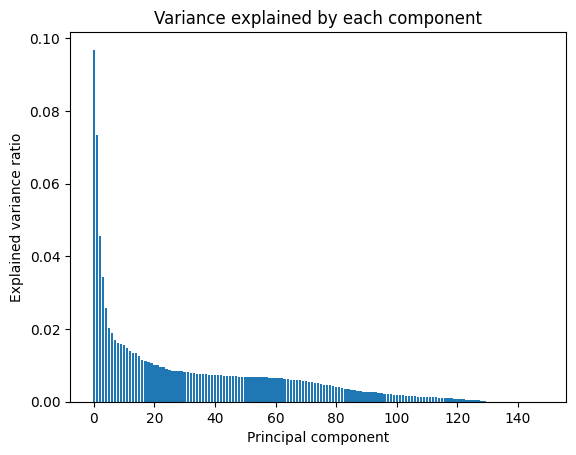

In [52]:
plt.bar(range(len(gen_demo_pca_test.explained_variance_ratio_)), gen_demo_pca_test.explained_variance_ratio_)
plt.title("Variance explained by each component")
plt.xlabel("Principal component")
plt.ylabel("Explained variance ratio")
plt.show()

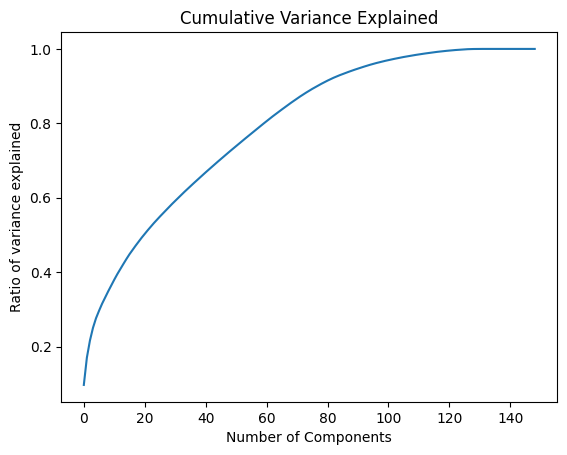

In [53]:
plt.plot(range(len(gen_demo_pca_test.explained_variance_ratio_)),np.cumsum(gen_demo_pca_test.explained_variance_ratio_), '-')
plt.title("Cumulative Variance Explained")
plt.xlabel("Number of Components")
plt.ylabel("Ratio of variance explained")
plt.show()

In [54]:
# Re-apply PCA to the data while selecting for number of components to retain.
pca_mod = PCA(n_components=60)
gen_demo_pca_data = pca_mod.fit_transform(gen_demo_clean_scaled)

### Discussion 2.2: Perform Dimensionality Reduction

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding dimensionality reduction. How many principal components / transformed features are you retaining for the next step of the analysis?)

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [81]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.
def map_pc_weights_to_features(df,pca_model,component_num):
    weights_df=pd.DataFrame(pca_model.components_,columns=list(df))
    pca_feature_map = weights_df.loc[component_num].sort_values(ascending = False)
    return pca_feature_map

In [82]:
map_pc_weights_to_features(gen_demo_clean_scaled,pca_mod,0)

LP_STATUS_GROB_1.0                0.200791
HH_EINKOMMEN_SCORE                0.187164
PLZ8_ANTG3                        0.181773
CAMEO_INTL_2015_WEALTH            0.180042
PLZ8_ANTG4                        0.175559
ORTSGR_KLS9                       0.155814
EWDICHTE                          0.154190
FINANZ_HAUSBAUER                  0.148705
FINANZ_SPARER                     0.132733
KBA05_ANTG4                       0.130086
FINANZTYP_1                       0.126371
LP_STATUS_FEIN_2.0                0.125960
LP_STATUS_FEIN_1.0                0.124821
PLZ8_ANTG2                        0.124819
KBA05_ANTG3                       0.118713
ANZ_HAUSHALTE_AKTIV               0.116794
ARBEIT                            0.112931
CAMEO_DEUG_2015_9                 0.112154
PRAEGENDE_JUGENDJAHRE_MOVEMENT    0.107758
RELAT_AB                          0.107246
SEMIO_PFLICHT                     0.098947
PRAEGENDE_JUGENDJAHRE_DECADE      0.094757
SEMIO_REL                         0.093922
CAMEO_DEUG_

In [83]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.
map_pc_weights_to_features(gen_demo_clean_scaled,pca_mod,1)


ALTERSKATEGORIE_GROB              0.227007
FINANZ_VORSORGER                  0.213216
ZABEOTYP_3                        0.200322
SEMIO_ERL                         0.178328
SEMIO_LUST                        0.158831
RETOURTYP_BK_S                    0.154795
W_KEIT_KIND_HH                    0.126174
LP_STATUS_FEIN_1.0                0.108854
CJT_GESAMTTYP_2.0                 0.105413
FINANZ_HAUSBAUER                  0.099835
FINANZTYP_5                       0.098620
FINANZTYP_2                       0.085718
PLZ8_ANTG3                        0.079803
PLZ8_ANTG4                        0.078191
EWDICHTE                          0.077934
ORTSGR_KLS9                       0.076927
SEMIO_KRIT                        0.076527
SHOPPER_TYP_3.0                   0.071559
CAMEO_INTL_2015_WEALTH            0.071544
FINANZ_MINIMALIST                 0.071305
CJT_GESAMTTYP_1.0                 0.069583
LP_FAMILIE_FEIN_1.0               0.067880
LP_FAMILIE_GROB_1.0               0.067880
FINANZTYP_6

In [84]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.
map_pc_weights_to_features(gen_demo_clean_scaled,pca_mod,2)


SEMIO_VERT                        0.319636
SEMIO_FAM                         0.261673
SEMIO_SOZ                         0.258130
SEMIO_KULT                        0.252626
FINANZTYP_5                       0.135323
FINANZ_MINIMALIST                 0.125824
SHOPPER_TYP_0.0                   0.123312
ZABEOTYP_1                        0.113053
SEMIO_REL                         0.112963
SEMIO_MAT                         0.088874
RETOURTYP_BK_S                    0.075808
GREEN_AVANTGARDE                  0.068195
W_KEIT_KIND_HH                    0.064150
ORTSGR_KLS9                       0.064082
EWDICHTE                          0.063776
SHOPPER_TYP_1.0                   0.055392
PLZ8_ANTG4                        0.051273
ZABEOTYP_6                        0.051222
PLZ8_ANTG3                        0.051136
FINANZ_VORSORGER                  0.047725
LP_STATUS_FEIN_1.0                0.047568
LP_STATUS_FEIN_10.0               0.046402
LP_STATUS_GROB_5.0                0.046402
LP_STATUS_F

### Discussion 2.3: Interpret Principal Components

The first principal component - seems to be related to household income and family size:
* Has a strong positive correlaton with:
    * LP_STATUS_GROB_1.0  (low income earners)
    * HH_EINKOMMEN_SCORE (Estimated household net income)
* Has a strong negative correlaton with:
    * KBA05_ANTG1 (lower share of 1-2 family homes)
    * PLZ8_ANTG1  (Number of 1-2 family houses in the PLZ8 region)

The second principal component - seems to be related to age and savings:
* Has a strong positive correlaton with:
    * ALTERSKATEGORIE_GROB   (Estimated age based on given name analysis)
    * FINANZ_VORSORGER (Financial typology - provision)
* Has a strong negative correlaton with:
    * FINANZ_SPARER  (Financial typology - saver)
    * PRAEGENDE_JUGENDJAHRE_DECADE  (Dominating decade of person's youth)

The third principal component - seems to be related to personality and gender:
* Has a strong positive correlaton with:
    * SEMIO_VERT    (Personality typology)
    * SEMIO_FAM  (Personality typology)
* Has a strong negative correlaton with:
    * SEMIO_KAEM  (Personality typology)
    * ANREDE_KZ  (Gender)

## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [71]:
from sklearn.cluster import KMeans
def calc_kmeans_score(data, k):
    #instantiate kmeans object
    kmeans = KMeans(n_clusters=k)
    # Then fit the model 
    model = kmeans.fit(data)
    # Obtain a score related to the model fit
    score = np.abs(model.score(data))
    return score

scores = []
cluster_counts = list(range(2,30,2))

for k in cluster_counts:
    scores.append(calc_kmeans_score(gen_demo_pca_data, k))

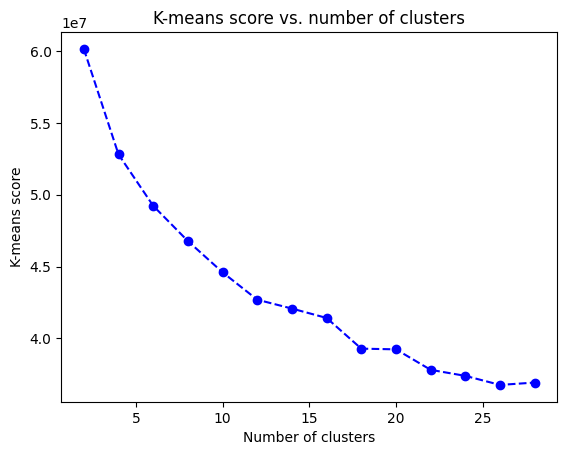

In [72]:
# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.
plt.plot(cluster_counts, scores, linestyle='--', marker='o', color='b');
plt.xlabel('Number of clusters');
plt.ylabel('K-means score');
plt.title('K-means score vs. number of clusters');  

In [73]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.
kmeans = KMeans(n_clusters=18)
model = kmeans.fit(gen_demo_pca_data)
gen_demo_pred = model.predict(gen_demo_pca_data)

### Discussion 3.1: Apply Clustering to General Population

Based on the scree plot I can see an elbow at around 18 clusters so have decided to create 18 population segments using Kmeans.

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [ ]:
# Load in the customer demographics data.
customers = 

In [ ]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.



### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

In [ ]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.



In [ ]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?



In [ ]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?



### Discussion 3.3: Compare Customer Data to Demographics Data

(Double-click this cell and replace this text with your own text, reporting findings and conclusions from the clustering analysis. Can we describe segments of the population that are relatively popular with the mail-order company, or relatively unpopular with the company?)

> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.